In [2]:
import pandas as pd  #pacotes
import numpy as np   #calculo numerico
import glob          #listas
#Codigo para declarar um pyarrow parquet - Willian - 29/05/2018
import pyarrow.parquet as pq
#uproot serve para ler a partir o python um arquivo em tree root
#import uproot
import os, sys
from os import path
import datetime
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
%matplotlib inline

In [3]:
%run def_functions.ipynb
%run def_functions_hits.ipynb
%run def_functions_fits.ipynb


In [4]:
'''
list_ON = ['20200824','20200825','20200826','20200827','20200828']
list_OFF = ['20200629','20200630','20200701','20200702','20200703']
list_ONA = ['20200615','20200616','20200617','20200618','20200619']
list_OFF2 = ['20200624','20200625','20200626','20200627','20200628']
list_OFF3 = ['20200704','20200705','20200706','20200707','20200708']
list_OFF4 = ['20200709','20200710','20200711','20200712','20200713']
list_OFF5 = ['20200714','20200715','20200716','20200717','20200718']
list_OFF6 = ['20200719','20200720','20200721','20200722','20200723']
'''

# para 30 dias
list_ON = [
           '20200820','20200821','20200822','20200823','20200824','20200825','20200826',
           '20200827','20200828','20200829','20200830','20200831','20200901','20200902',
           '20200903','20200904','20200905','20200906','20200907','20200908','20200909',
           '20200910','20200911','20200912','20200913','20200924','20200925','20200926',
           '20200927','20200928'
          ]

list_OFF = [
            '20200624','20200625','20200626','20200627','20200628','20200629','20200630',
            '20200701','20200702','20200703','20200704','20200705','20200706','20200707',
            '20200708','20200709','20200710','20200711','20200712','20200713','20200714',
            '20200715','20200716','20200717','20200718','20200719','20200720','20200721',
            '20200722','20200723'
           ]

list_ON2 = [
            '20201001','20201002','20201003','20201004','20201005','20201006','20201007',
            '20201008','20201009','20201010','20201011','20201012','20201013','20201014',
            '20201015','20201016','20201017','20201018','20201019','20201020','20201021',
            '20201022','20201023','20201024','20201025','20201026','20201027','20201028',
            '20201029','20201030'
           ]

list_ON3 = [
            '20201101','20201102','20201103','20201104','20201105','20201106','20201107',
            '20201108','20201109','20201110','20201111','20201112','20201113','20201114',
            '20201115','20201116','20201117','20201118','20201119','20201120','20201121',
            '20201122','20201123','20201124','20201125','20201126','20201127','20201128',
            '20201129','20201130']

list_ON4 = [
            '20201201','20201202','20201203','20201204','20201205','20201206','20201207',
            '20201208','20201209','20201210','20201211','20201212','20201213','20201214',
            '20201215','20201216','20201217','20201218','20201219','20201220','20201221',
            '20201222','20201223','20201224','20201225','20201226','20201227','20201228',
            '20201229','20201230'
           ]


In [4]:
#chi_sq_tab = 2.366  # chi quadrado tabelado para 3 graus de liberdades com 50%
#chi_sq_tab = 6.251  # chi quadrado tabelado para 3 graus de liberdades com 90%
chi_sq_tab = 7.815  # chi quadrado tabelado para 3 graus de liberdades com 95%
#chi_sq_tab = 10.597  # chi quadrado tabelado para 3 graus de liberdades com 995%
rh, rw = 150, 150
prompt_mean, prompt_var = 61.45215100965759, 1337.7332240825515
delay_mean, delay_var = 94.3970297029703, 4899.284941672385 
time_mean, time_var = 12.70, 12.70
itime_mean, itime_var = 1/12.70, 1/(12.70**2)

IBD_Esperado = 6610 #eventos por dia


## Função para processar lista

In [5]:
bins_interval = [63.134941, 66.91160302, 70.68826504, 74.46492707, 78.24158909,
 82.01825112, 85.79491314, 89.57157517, 93.34823719, 97.12489922,
 100.90156124, 104.67822326, 108.45488529, 112.23154731, 116.00820934, 
 119.78487136, 123.56153339, 127.33819541, 131.11485744, 134.89151946,
 138.66818149, 142.44484351, 146.22150553, 149.99816756, 153.77482958,
 157.55149161, 161.32815363, 165.10481566, 168.88147768, 172.65813971,
 176.43480173, 180.21146375, 183.98812578, 187.7647878, 191.54144983,
 195.31811185, 199.09477388, 202.8714359, 206.64809793, 210.42475995,
 214.20142197, 217.978084, 221.75474602, 225.53140805, 229.30807007,
 233.0847321, 236.86139412, 240.63805615, 244.41471817, 248.19138019]

#print(bins_interval)

def fnt_search_pos (f_pe):
    arr = [i for i, j in enumerate(bins_interval) if j >= f_pe]
    if len(arr)==0:
        res=-1
    else:
        res = arr[0]
    return res

#print(fnt_search_pos(67))  #2
#print(fnt_search_pos(55))   #0
#print(fnt_search_pos(100))  #10
#print(fnt_search_pos(300))  #-1

In [6]:
def fnt_process_list_PD (p_list, p_h_PDP, p_h_PDD, p_h_PDT, p_h_PD_pPDF, p_list_bins):
    i_day = 0
    p_totalPositrons = 0
    p_totalNonSat = 0
    p_count_bin = [ [] for y in range(len(p_list)) ]
    p_dp_bin = [ [] for y in range(len(p_list)) ]
    p_dpr_bin = [ [] for y in range(len(p_list)) ]                      

    for sListDt in p_list:
        yyyy=int(sListDt[0:4]); mm=int(sListDt[4:6]); dd=int(sListDt[6:8])
    
        sDate = '{0:d}-{1:0>2d}-{2:0>2d}'.format(yyyy,mm,dd)
        sDir='data/{0:d}{1:0>2d}{2:0>2d}'.format(yyyy,mm,dd)
        print(sDir)
        lista = find_interval_date_pair(sDate,sDate,sDir)
        p_h_NonSat = []

        for file in lista:
            print(' >>> '+file)
            df = pd.read_parquet(file)
            dff = df[(df['p_satured']==0)&(df['d_satured']==0)
                            &(fnt_pe2MeV(df['p_Total_pe'])>=3)&(fnt_pe2MeV(df['p_Total_pe'])<=10)
                            &(fnt_pe2MeV(df['d_Total_pe'])>=1.6)&(fnt_pe2MeV(df['d_Total_pe'])<=7.12)
                            &(df['d_timeInverval']>=8)&(df['d_timeInverval']<=50)
                            &(df['d_mPMTs']>=25)
                    ]
            p_h_PDP.extend(dff['p_Total_pe'].values)
            p_h_PDD.extend(dff['d_Total_pe'].values)
            p_h_PDT.extend(dff['d_timeInverval'].values)
            p_h_PD_pPDF.extend(dff['p_PDF'].values)

            dfns = df[(df['p_satured']==0)&(df['d_satured']==0)]

            p_totalPositrons += df.count()[0]
            p_totalNonSat += dfns.count()[0]

            p_h_NonSat.extend(dff['p_Total_pe'].values)            

            #print(p_totalPositrons)
            #break
                
        print('calculando bin')
                      
        p_bin_NonSat = [ [] for y in range(len(p_list_bins)) ]
                      
        ## 1- Navegar na lista de prompt dos eventos filtrados e separá-los em bins de pe
        for iw in range(len(p_h_NonSat)):
            i_b_pos = fnt_search_pos(p_h_NonSat[iw])
            if (i_b_pos!=-1):
                p_bin_NonSat[i_b_pos].append(p_h_NonSat[iw])
        
        ## 2- Navegar na lista de bins e contar quantos eventos ocorreram no dia
        for sb in range(len(p_list_bins)):
            p_count_bin[i_day].append(len(p_bin_NonSat[sb]))

        ## 3- Navegar na lista de bins e calcular o desvio padrao e o desvio padrao medio
        ## não lembro pq fiz em loop separado do anterior - 19/08/2023
        for dpb in range(len(p_list_bins)):
            p_dp_bin[i_day].append(np.std(p_bin_NonSat[dpb]))
            p_dpr_bin[i_day].append(np.std(p_bin_NonSat[dpb])/len(p_bin_NonSat[dpb]))

        i_day += 1
        #break   ## Somente 1 dia de runs

    print('calculando sigmas')
    p_sigma_bin = []
    p_sigmar_bin = []
    p_std_bin = []
    for sbr in range(len(p_list_bins)):
        cday_NSat = []
        cday_Relat = []
        cday_Std = []
        for dd in range(i_day):
            cday_NSat.append(p_count_bin[dd][sbr])
            cday_Relat.append(p_dpr_bin[dd][sbr])
            cday_Std.append(p_dp_bin[dd][sbr])
            
        p_sigma_bin.append(np.sum(cday_NSat)/i_day)  # contagem de eventos/dia dividido pela qtde de dias
        p_sigmar_bin.append(np.sum(cday_Relat)/i_day) # contagem de desvio padrao/dia dividido pela qtde de dias
        p_std_bin.append(np.sum(cday_Std)/i_day) # contagem de desvio padrao relativo/dia (dp/qtde de eventos do bin) dividido pela qtde de dias

    return p_totalPositrons, p_totalNonSat, p_sigma_bin, p_sigmar_bin, p_std_bin


In [9]:
# initializing list
test_list = [2, 4, 6, 8, 10, 12] # 2-4:0, 4-6:1,6-8:2,...
 
# printing list
print("The original list : " + str(test_list))
 
# Positions of maximum element in list
# Using list comprehension + max() + enumerate()
temp = 5.99 #max(test_list)
res = [i for i, j in enumerate(test_list) if j >= temp][0]
 
# Printing result
print("The Positions of maximum element : " + str(res))

The original list : [2, 4, 6, 8, 10, 12]
The Positions of maximum element : 2


In [ ]:
'''
def fnt_process_error_PD (p_list, p_h_NonSat, p_list_bins):
    i_day = 0
    p_sigma_bin = []

    for sListDt in p_list:
        yyyy=int(sListDt[0:4]); mm=int(sListDt[4:6]); dd=int(sListDt[6:8])
    
        sDate = '{0:d}-{1:0>2d}-{2:0>2d}'.format(yyyy,mm,dd)
        sDir='data/{0:d}{1:0>2d}{2:0>2d}'.format(yyyy,mm,dd)
        print(sDir)
        lista = find_interval_date_pair(sDate,sDate,sDir)
        #p_day_NonSat = []
        #p_sigma_NonSat = [0 for x in range(len(p_list_bins))]

        for file in lista:
            df = pd.read_parquet(file)
            dff = df[(df['p_satured']==0)&(df['d_satured']==0)
                    ]
            
            p_h_NonSat.extend(dff['p_Total_pe'].values)
            #p_day_NonSat.extend(dff['p_Total_pe'].values)
            #for sns in range(len(p_list_bins)):
            #    p_bin_NonSat[sb] += np.std(???)  ## aqui devo separar cada bin do NonSat e calcular o desvio padrao

            #break
        
        i_day += 1
        #break   ## Somente 1 dia de runs

    for iw in range(len(p_h_NonSat)):
        i_b_pos = fnt_search_pos(p_h_NonSat[iw])
        if (i_b_pos!=-1):
            p_bin_NonSat[i_b_pos].append(p_h_NonSat[iw])
        
    for sb in range(len(p_list_bins)):
        p_sigma_bin.append(np.std(p_bin_NonSat[sb]))
    
        
    return (p_sigma_bin/(i_day**0.5)) ##erro de cada bin dividido por raiz(N)
'''

## Processamento para OFF

In [9]:
print('Inicio',datetime.datetime.now())
h_PDP_OFF = []
h_PDD_OFF = []
h_PDT_OFF = []
h_PD_pPDF_OFF = []
totalPositrons_OFF = 0
totalNonSat_OFF = 0
h_Sig_OFF = []
h_SigR_OFF = []
h_Std_OFF = []

totalPositrons_OFF, totalNonSat_OFF, h_Sig_OFF, h_SigR_OFF, h_Std_OFF = fnt_process_list_PD(list_OFF, h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, h_PD_pPDF_OFF, bins_interval)
                            
print(len(h_PDP_OFF))
print(len(h_PDD_OFF))
print(len(h_PDT_OFF))
print('Em ',len(list_OFF),' dias: ',totalPositrons_OFF)
print('Por dia: ',totalPositrons_OFF/len(list_OFF))
print('Em Hz: ',totalPositrons_OFF/len(list_OFF)/86400) 
print('Em ',len(list_OFF),' dias (NS): ',totalNonSat_OFF)
print('Por dia (NS): ',totalNonSat_OFF/len(list_OFF))
print('Em Hz (NS): ',totalNonSat_OFF/len(list_OFF)/86400) 

print(h_Sig_OFF)
print(np.sum(h_Sig_OFF))

hg_Sig_OFF = [(x**0.5) for x in h_Sig_OFF]
print(hg_Sig_OFF)

        
print('Fim',datetime.datetime.now())

Inicio 2024-02-29 04:53:32.751130
data/20200624
 >>> data/20200624\AngraRun_1592968781785_processed_pair.parq
 >>> data/20200624\AngraRun_1592970621971_processed_pair.parq
 >>> data/20200624\AngraRun_1592972436159_processed_pair.parq
 >>> data/20200624\AngraRun_1592974231566_processed_pair.parq
 >>> data/20200624\AngraRun_1592976037121_processed_pair.parq
 >>> data/20200624\AngraRun_1592977858387_processed_pair.parq
 >>> data/20200624\AngraRun_1592979665864_processed_pair.parq
 >>> data/20200624\AngraRun_1592981516877_processed_pair.parq
 >>> data/20200624\AngraRun_1592983294101_processed_pair.parq
 >>> data/20200624\AngraRun_1592985112000_processed_pair.parq
 >>> data/20200624\AngraRun_1592986926173_processed_pair.parq
 >>> data/20200624\AngraRun_1592988750116_processed_pair.parq
 >>> data/20200624\AngraRun_1592990588137_processed_pair.parq
 >>> data/20200624\AngraRun_1592992402583_processed_pair.parq
 >>> data/20200624\AngraRun_1592994205177_processed_pair.parq
 >>> data/20200624\Ang

 >>> data/20200626\AngraRun_1593206544112_processed_pair.parq
 >>> data/20200626\AngraRun_1593208371564_processed_pair.parq
 >>> data/20200626\AngraRun_1593210176950_processed_pair.parq
 >>> data/20200626\AngraRun_1593211988302_processed_pair.parq
 >>> data/20200626\AngraRun_1593213824564_processed_pair.parq
 >>> data/20200626\AngraRun_1593215636650_processed_pair.parq
 >>> data/20200626\AngraRun_1593217448948_processed_pair.parq
 >>> data/20200626\AngraRun_1593219284612_processed_pair.parq
 >>> data/20200626\AngraRun_1593221077678_processed_pair.parq
 >>> data/20200626\AngraRun_1593222897369_processed_pair.parq
 >>> data/20200626\AngraRun_1593224712735_processed_pair.parq
 >>> data/20200626\AngraRun_1593226536470_processed_pair.parq
calculando bin
data/20200627
 >>> data/20200627\AngraRun_1593228345443_processed_pair.parq
 >>> data/20200627\AngraRun_1593230126585_processed_pair.parq
 >>> data/20200627\AngraRun_1593231976220_processed_pair.parq
 >>> data/20200627\AngraRun_1593233789242

C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 >>> data/20200629\AngraRun_1593402554848_processed_pair.parq
 >>> data/20200629\AngraRun_1593404363073_processed_pair.parq
 >>> data/20200629\AngraRun_1593406151651_processed_pair.parq
 >>> data/20200629\AngraRun_1593407986229_processed_pair.parq
 >>> data/20200629\AngraRun_1593409810635_processed_pair.parq
 >>> data/20200629\AngraRun_1593411599032_processed_pair.parq
 >>> data/20200629\AngraRun_1593413412016_processed_pair.parq
 >>> data/20200629\AngraRun_1593415227127_processed_pair.parq
 >>> data/20200629\AngraRun_1593417052911_processed_pair.parq
 >>> data/20200629\AngraRun_1593418855000_processed_pair.parq
 >>> data/20200629\AngraRun_1593420699294_processed_pair.parq
 >>> data/20200629\AngraRun_1593422503730_processed_pair.parq
 >>> data/20200629\AngraRun_1593424334811_processed_pair.parq
 >>> data/20200629\AngraRun_1593426148311_processed_pair.parq
 >>> data/20200629\AngraRun_1593427962294_processed_pair.parq
 >>> data/20200629\AngraRun_1593429783183_processed_pair.parq
 >>> dat

 >>> data/20200701\AngraRun_1593642128353_processed_pair.parq
 >>> data/20200701\AngraRun_1593643926904_processed_pair.parq
 >>> data/20200701\AngraRun_1593645746171_processed_pair.parq
 >>> data/20200701\AngraRun_1593647560711_processed_pair.parq
 >>> data/20200701\AngraRun_1593649393604_processed_pair.parq
 >>> data/20200701\AngraRun_1593651219030_processed_pair.parq
 >>> data/20200701\AngraRun_1593653016402_processed_pair.parq
 >>> data/20200701\AngraRun_1593654831735_processed_pair.parq
 >>> data/20200701\AngraRun_1593656659913_processed_pair.parq
 >>> data/20200701\AngraRun_1593658449623_processed_pair.parq
calculando bin
data/20200702
 >>> data/20200702\AngraRun_1593660290947_processed_pair.parq
 >>> data/20200702\AngraRun_1593662113972_processed_pair.parq
 >>> data/20200702\AngraRun_1593663908898_processed_pair.parq
 >>> data/20200702\AngraRun_1593665706499_processed_pair.parq
 >>> data/20200702\AngraRun_1593667535063_processed_pair.parq
 >>> data/20200702\AngraRun_1593669365573

 >>> data/20200704\AngraRun_1593879882585_processed_pair.parq
 >>> data/20200704\AngraRun_1593881696332_processed_pair.parq
 >>> data/20200704\AngraRun_1593883504093_processed_pair.parq
 >>> data/20200704\AngraRun_1593885316403_processed_pair.parq
 >>> data/20200704\AngraRun_1593887137732_processed_pair.parq
 >>> data/20200704\AngraRun_1593888942574_processed_pair.parq
 >>> data/20200704\AngraRun_1593890784837_processed_pair.parq
 >>> data/20200704\AngraRun_1593892566771_processed_pair.parq
 >>> data/20200704\AngraRun_1593894388558_processed_pair.parq
 >>> data/20200704\AngraRun_1593896216271_processed_pair.parq
 >>> data/20200704\AngraRun_1593898011622_processed_pair.parq
 >>> data/20200704\AngraRun_1593899860790_processed_pair.parq
 >>> data/20200704\AngraRun_1593901641921_processed_pair.parq
 >>> data/20200704\AngraRun_1593903477005_processed_pair.parq
 >>> data/20200704\AngraRun_1593905279261_processed_pair.parq
 >>> data/20200704\AngraRun_1593907095808_processed_pair.parq
 >>> dat

 >>> data/20200707\AngraRun_1594117659071_processed_pair.parq
 >>> data/20200707\AngraRun_1594119444887_processed_pair.parq
 >>> data/20200707\AngraRun_1594121270186_processed_pair.parq
 >>> data/20200707\AngraRun_1594123088116_processed_pair.parq
 >>> data/20200707\AngraRun_1594124912662_processed_pair.parq
 >>> data/20200707\AngraRun_1594126711624_processed_pair.parq
 >>> data/20200707\AngraRun_1594128529329_processed_pair.parq
 >>> data/20200707\AngraRun_1594130340773_processed_pair.parq
 >>> data/20200707\AngraRun_1594132160943_processed_pair.parq
 >>> data/20200707\AngraRun_1594133963010_processed_pair.parq
 >>> data/20200707\AngraRun_1594135796033_processed_pair.parq
 >>> data/20200707\AngraRun_1594137605385_processed_pair.parq
 >>> data/20200707\AngraRun_1594139422686_processed_pair.parq
 >>> data/20200707\AngraRun_1594141230628_processed_pair.parq
 >>> data/20200707\AngraRun_1594143062024_processed_pair.parq
 >>> data/20200707\AngraRun_1594144857807_processed_pair.parq
 >>> dat

 >>> data/20200710\AngraRun_1594355390227_processed_pair.parq
 >>> data/20200710\AngraRun_1594357221992_processed_pair.parq
 >>> data/20200710\AngraRun_1594359020518_processed_pair.parq
 >>> data/20200710\AngraRun_1594360832883_processed_pair.parq
 >>> data/20200710\AngraRun_1594362642437_processed_pair.parq
 >>> data/20200710\AngraRun_1594364455697_processed_pair.parq
 >>> data/20200710\AngraRun_1594366290344_processed_pair.parq
 >>> data/20200710\AngraRun_1594368115330_processed_pair.parq
 >>> data/20200710\AngraRun_1594369911788_processed_pair.parq
 >>> data/20200710\AngraRun_1594371744754_processed_pair.parq
 >>> data/20200710\AngraRun_1594373534969_processed_pair.parq
 >>> data/20200710\AngraRun_1594375354038_processed_pair.parq
 >>> data/20200710\AngraRun_1594377175411_processed_pair.parq
 >>> data/20200710\AngraRun_1594378988382_processed_pair.parq
 >>> data/20200710\AngraRun_1594380798310_processed_pair.parq
 >>> data/20200710\AngraRun_1594382616884_processed_pair.parq
 >>> dat

 >>> data/20200712\AngraRun_1594594976525_processed_pair.parq
 >>> data/20200712\AngraRun_1594596795547_processed_pair.parq
 >>> data/20200712\AngraRun_1594598602281_processed_pair.parq
 >>> data/20200712\AngraRun_1594600430324_processed_pair.parq
 >>> data/20200712\AngraRun_1594602238368_processed_pair.parq
 >>> data/20200712\AngraRun_1594604041250_processed_pair.parq
 >>> data/20200712\AngraRun_1594605865118_processed_pair.parq
 >>> data/20200712\AngraRun_1594607694932_processed_pair.parq
calculando bin
data/20200713
 >>> data/20200713\AngraRun_1594609503254_processed_pair.parq
 >>> data/20200713\AngraRun_1594611303906_processed_pair.parq
 >>> data/20200713\AngraRun_1594613141987_processed_pair.parq
 >>> data/20200713\AngraRun_1594614970363_processed_pair.parq
 >>> data/20200713\AngraRun_1594616766212_processed_pair.parq
 >>> data/20200713\AngraRun_1594618595483_processed_pair.parq
 >>> data/20200713\AngraRun_1594620390888_processed_pair.parq
 >>> data/20200713\AngraRun_1594622213212

 >>> data/20200715\AngraRun_1594832707578_processed_pair.parq
 >>> data/20200715\AngraRun_1594834515176_processed_pair.parq
 >>> data/20200715\AngraRun_1594836337985_processed_pair.parq
 >>> data/20200715\AngraRun_1594838136616_processed_pair.parq
 >>> data/20200715\AngraRun_1594839959265_processed_pair.parq
 >>> data/20200715\AngraRun_1594841770703_processed_pair.parq
 >>> data/20200715\AngraRun_1594843602315_processed_pair.parq
 >>> data/20200715\AngraRun_1594845392871_processed_pair.parq
 >>> data/20200715\AngraRun_1594847226735_processed_pair.parq
 >>> data/20200715\AngraRun_1594849033825_processed_pair.parq
 >>> data/20200715\AngraRun_1594850842869_processed_pair.parq
 >>> data/20200715\AngraRun_1594852670165_processed_pair.parq
 >>> data/20200715\AngraRun_1594854471313_processed_pair.parq
 >>> data/20200715\AngraRun_1594856280619_processed_pair.parq
 >>> data/20200715\AngraRun_1594858108293_processed_pair.parq
 >>> data/20200715\AngraRun_1594859913272_processed_pair.parq
 >>> dat

 >>> data/20200718\AngraRun_1595070479263_processed_pair.parq
 >>> data/20200718\AngraRun_1595072295581_processed_pair.parq
 >>> data/20200718\AngraRun_1595074106975_processed_pair.parq
 >>> data/20200718\AngraRun_1595075915075_processed_pair.parq
 >>> data/20200718\AngraRun_1595077732898_processed_pair.parq
 >>> data/20200718\AngraRun_1595079545483_processed_pair.parq
 >>> data/20200718\AngraRun_1595081358458_processed_pair.parq
 >>> data/20200718\AngraRun_1595083180263_processed_pair.parq
 >>> data/20200718\AngraRun_1595084993449_processed_pair.parq
 >>> data/20200718\AngraRun_1595086804017_processed_pair.parq
 >>> data/20200718\AngraRun_1595088629710_processed_pair.parq
 >>> data/20200718\AngraRun_1595090440281_processed_pair.parq
 >>> data/20200718\AngraRun_1595092250264_processed_pair.parq
 >>> data/20200718\AngraRun_1595094069862_processed_pair.parq
 >>> data/20200718\AngraRun_1595095879511_processed_pair.parq
 >>> data/20200718\AngraRun_1595097696255_processed_pair.parq
 >>> dat

 >>> data/20200721\AngraRun_1595308242858_processed_pair.parq
 >>> data/20200721\AngraRun_1595310072106_processed_pair.parq
 >>> data/20200721\AngraRun_1595311875396_processed_pair.parq
 >>> data/20200721\AngraRun_1595313692357_processed_pair.parq
 >>> data/20200721\AngraRun_1595315505644_processed_pair.parq
 >>> data/20200721\AngraRun_1595317312163_processed_pair.parq
 >>> data/20200721\AngraRun_1595319147442_processed_pair.parq
 >>> data/20200721\AngraRun_1595320938722_processed_pair.parq
 >>> data/20200721\AngraRun_1595322774013_processed_pair.parq
 >>> data/20200721\AngraRun_1595324589541_processed_pair.parq
 >>> data/20200721\AngraRun_1595326389641_processed_pair.parq
 >>> data/20200721\AngraRun_1595328208419_processed_pair.parq
 >>> data/20200721\AngraRun_1595330030113_processed_pair.parq
 >>> data/20200721\AngraRun_1595331830997_processed_pair.parq
 >>> data/20200721\AngraRun_1595333648984_processed_pair.parq
 >>> data/20200721\AngraRun_1595335490359_processed_pair.parq
 >>> dat

 >>> data/20200723\AngraRun_1595547810914_processed_pair.parq
 >>> data/20200723\AngraRun_1595549622172_processed_pair.parq
 >>> data/20200723\AngraRun_1595551457375_processed_pair.parq
 >>> data/20200723\AngraRun_1595553268616_processed_pair.parq
 >>> data/20200723\AngraRun_1595555060892_processed_pair.parq
 >>> data/20200723\AngraRun_1595556906591_processed_pair.parq
 >>> data/20200723\AngraRun_1595558692722_processed_pair.parq
calculando bin
calculando sigmas
125073
125073
125073
Em  30  dias:  493463658
Por dia:  16448788.6
Em Hz:  190.37949768518519
Em  30  dias (NS):  317742610
Por dia (NS):  10591420.333333334
Em Hz (NS):  122.58588348765433
[2.0, 399.6666666666667, 373.5, 350.2, 327.56666666666666, 291.3666666666667, 269.0, 244.66666666666666, 212.8, 188.23333333333332, 159.83333333333334, 140.1, 121.93333333333334, 106.33333333333333, 95.1, 87.36666666666666, 75.33333333333333, 67.36666666666666, 61.733333333333334, 55.1, 48.86666666666667, 47.4, 41.13333333333333, 39.13333333

In [ ]:
#print(h_Sig_OFF)
#print([x*2310 for x in h_SigR_OFF])
#print(np.sum(h_Std_OFF))
#print([(x/np.sum(h_Std_OFF))*2310/2 for x in h_Std_OFF])
#print(h_Std_OFF)

g_bin_PDP = [ [] for y in range(len(bins_interval)) ]
                      
for iw in range(len(h_PDP_OFF)):
    i_b_pos = fnt_search_pos(h_PDP_OFF[iw])
    if (i_b_pos!=-1):
        g_bin_PDP[i_b_pos].append(h_PDP_OFF[iw])

g_count_bin = [ [] for y in range(len(bins_interval)) ]
g_count_binSQR = [ [] for y in range(len(bins_interval)) ]
for sb in range(len(bins_interval)):
    g_count_bin[sb].append(len(g_bin_PDP[sb]))
    g_count_binSQR[sb].append((len(g_bin_PDP[sb])**0.5)/(5**0.5))

        
print(np.sum(g_count_bin))
print(g_count_bin)
print(g_count_binSQR)
#print([(x/(5**0.5)) for x in g_count_binSQR])


In [ ]:
print('Inicio',datetime.datetime.now())

cday_PD_OFF = []
cday_NSat_OFF = []
cday_All_OFF = []

for sListDt in list_OFF:
    yyyy=int(sListDt[0:4]); mm=int(sListDt[4:6]); dd=int(sListDt[6:8])
    
    sDate = '{0:d}-{1:0>2d}-{2:0>2d}'.format(yyyy,mm,dd)
    sDir='data/{0:d}{1:0>2d}{2:0>2d}'.format(yyyy,mm,dd)
    print(sDir)
    lista = find_interval_date_pair(sDate,sDate,sDir)

    ctot_PD_OFF = 0
    ctot_NSat_OFF = 0
    ctot_All_OFF = 0
    
    for file in lista:
        df = pd.read_parquet(file)
        dff = df[(df['p_satured']==0)&(df['d_satured']==0)
                            &(fnt_pe2MeV(df['p_Total_pe'])>=3)&(fnt_pe2MeV(df['p_Total_pe'])<=10)
                            &(fnt_pe2MeV(df['d_Total_pe'])>=1.6)&(fnt_pe2MeV(df['d_Total_pe'])<=7.12)
                            &(df['d_timeInverval']>=8)&(df['d_timeInverval']<=50)
                            &(df['d_mPMTs']>=25)
                ]
        ctot_PD_OFF+=dff.count()[0]
        ctot_NSat_OFF+=df[(df['p_satured']==0)&(df['d_satured']==0)].count()[0]
        ctot_All_OFF+=df.count()[0]
        
    cday_PD_OFF.append(ctot_PD_OFF)
    cday_NSat_OFF.append(ctot_NSat_OFF)
    cday_All_OFF.append(ctot_All_OFF)

print('Contagem diária eventos filtrados (OFF)',cday_PD_OFF)
print('Contagem diária eventos não saturados (OFF)',cday_NSat_OFF)
print('Contagem diária eventos totais (OFF)',cday_All_OFF)
print('Média / DP eventos não saturados (OFF)',np.mean(cday_NSat_OFF),np.std(cday_NSat_OFF))
        
print('Fim',datetime.datetime.now())

## Processamento para ON

In [13]:
print('Inicio',datetime.datetime.now())


h_PDP_ON = []
h_PDD_ON = []
h_PDT_ON = []
h_PD_pPDF_ON = []
h_Sig_ON = []
h_SigR_ON = []
h_Std_ON = []

totalPositrons_ON = 0
totalNonSat_ON = 0
i_day = 0

totalPositrons_ON, totalNonSat_ON, h_Sig_ON, h_SigR_ON, h_Std_ON = fnt_process_list_PD(list_ON, h_PDP_ON, h_PDD_ON, h_PDT_ON, h_PD_pPDF_ON, bins_interval)

                            
#print(len(h_P_ON))
#print(len(h_D_ON))
print(len(h_PDP_ON))
print(len(h_PDD_ON))
print(len(h_PDT_ON))
#print('Em ',len(list_OFF),' dias: ',totalPositrons_OFF)
print('Em ',len(list_ON),' dias: ',totalPositrons_ON)
print('Por dia: ',totalPositrons_ON/len(list_ON))
print('Em Hz: ',totalPositrons_ON/len(list_ON)/86400) 
print('Em ',len(list_ON),' dias (NS): ',totalNonSat_ON)
print('Por dia (NS): ',totalNonSat_ON/len(list_ON))
print('Em Hz (NS): ',totalNonSat_ON/len(list_ON)/86400) 

hg_Sig_ON = [(x**0.5) for x in h_Sig_ON]
print(hg_Sig_ON)

print('Fim',datetime.datetime.now())


Inicio 2024-02-29 16:38:43.582279
data/20200820
 >>> data/20200820\AngraRun_1597892730400_processed_pair.parq
 >>> data/20200820\AngraRun_1597894529040_processed_pair.parq
 >>> data/20200820\AngraRun_1597896367961_processed_pair.parq
 >>> data/20200820\AngraRun_1597898173864_processed_pair.parq
 >>> data/20200820\AngraRun_1597899986913_processed_pair.parq
 >>> data/20200820\AngraRun_1597901801357_processed_pair.parq
 >>> data/20200820\AngraRun_1597903620204_processed_pair.parq
 >>> data/20200820\AngraRun_1597905425207_processed_pair.parq
 >>> data/20200820\AngraRun_1597907236018_processed_pair.parq
 >>> data/20200820\AngraRun_1597909056407_processed_pair.parq
 >>> data/20200820\AngraRun_1597910864209_processed_pair.parq
 >>> data/20200820\AngraRun_1597912681218_processed_pair.parq
 >>> data/20200820\AngraRun_1597914505584_processed_pair.parq
 >>> data/20200820\AngraRun_1597916322441_processed_pair.parq
 >>> data/20200820\AngraRun_1597918138036_processed_pair.parq
 >>> data/20200820\Ang

 >>> data/20200822\AngraRun_1598130447894_processed_pair.parq
 >>> data/20200822\AngraRun_1598132277534_processed_pair.parq
 >>> data/20200822\AngraRun_1598134086377_processed_pair.parq
 >>> data/20200822\AngraRun_1598135896942_processed_pair.parq
 >>> data/20200822\AngraRun_1598137734963_processed_pair.parq
 >>> data/20200822\AngraRun_1598139554623_processed_pair.parq
 >>> data/20200822\AngraRun_1598141362928_processed_pair.parq
 >>> data/20200822\AngraRun_1598143157153_processed_pair.parq
 >>> data/20200822\AngraRun_1598144991458_processed_pair.parq
 >>> data/20200822\AngraRun_1598146805736_processed_pair.parq
 >>> data/20200822\AngraRun_1598148601572_processed_pair.parq
 >>> data/20200822\AngraRun_1598150420569_processed_pair.parq
calculando bin
data/20200823
 >>> data/20200823\AngraRun_1598152238091_processed_pair.parq


C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 >>> data/20200823\AngraRun_1598154074321_processed_pair.parq
 >>> data/20200823\AngraRun_1598155878723_processed_pair.parq
 >>> data/20200823\AngraRun_1598157705056_processed_pair.parq
 >>> data/20200823\AngraRun_1598159509305_processed_pair.parq
 >>> data/20200823\AngraRun_1598161328889_processed_pair.parq
 >>> data/20200823\AngraRun_1598163144232_processed_pair.parq
 >>> data/20200823\AngraRun_1598164967843_processed_pair.parq
 >>> data/20200823\AngraRun_1598166758065_processed_pair.parq
 >>> data/20200823\AngraRun_1598168573738_processed_pair.parq
 >>> data/20200823\AngraRun_1598170383544_processed_pair.parq
 >>> data/20200823\AngraRun_1598172217421_processed_pair.parq
 >>> data/20200823\AngraRun_1598174022242_processed_pair.parq
 >>> data/20200823\AngraRun_1598175830997_processed_pair.parq
 >>> data/20200823\AngraRun_1598177661782_processed_pair.parq
 >>> data/20200823\AngraRun_1598179481151_processed_pair.parq
 >>> data/20200823\AngraRun_1598181306076_processed_pair.parq
 >>> dat

 >>> data/20200825\AngraRun_1598393665427_processed_pair.parq
 >>> data/20200825\AngraRun_1598395501879_processed_pair.parq
 >>> data/20200825\AngraRun_1598397286467_processed_pair.parq
 >>> data/20200825\AngraRun_1598399096759_processed_pair.parq
 >>> data/20200825\AngraRun_1598400924256_processed_pair.parq
 >>> data/20200825\AngraRun_1598402724921_processed_pair.parq
 >>> data/20200825\AngraRun_1598404543688_processed_pair.parq
 >>> data/20200825\AngraRun_1598406367020_processed_pair.parq
 >>> data/20200825\AngraRun_1598408173223_processed_pair.parq
 >>> data/20200825\AngraRun_1598409985361_processed_pair.parq
calculando bin
data/20200826
 >>> data/20200826\AngraRun_1598411807747_processed_pair.parq
 >>> data/20200826\AngraRun_1598413632785_processed_pair.parq
 >>> data/20200826\AngraRun_1598415446121_processed_pair.parq
 >>> data/20200826\AngraRun_1598417259848_processed_pair.parq
 >>> data/20200826\AngraRun_1598419067924_processed_pair.parq
 >>> data/20200826\AngraRun_1598420875716

 >>> data/20200828\AngraRun_1598631410928_processed_pair.parq
 >>> data/20200828\AngraRun_1598633227932_processed_pair.parq
 >>> data/20200828\AngraRun_1598635049283_processed_pair.parq
 >>> data/20200828\AngraRun_1598636866886_processed_pair.parq
 >>> data/20200828\AngraRun_1598638685459_processed_pair.parq
 >>> data/20200828\AngraRun_1598640499278_processed_pair.parq
 >>> data/20200828\AngraRun_1598642326653_processed_pair.parq
 >>> data/20200828\AngraRun_1598644126110_processed_pair.parq
 >>> data/20200828\AngraRun_1598645952170_processed_pair.parq
 >>> data/20200828\AngraRun_1598647751108_processed_pair.parq
 >>> data/20200828\AngraRun_1598649570397_processed_pair.parq
 >>> data/20200828\AngraRun_1598651380822_processed_pair.parq
 >>> data/20200828\AngraRun_1598653206185_processed_pair.parq
 >>> data/20200828\AngraRun_1598655005110_processed_pair.parq
 >>> data/20200828\AngraRun_1598656824192_processed_pair.parq
 >>> data/20200828\AngraRun_1598658641033_processed_pair.parq
 >>> dat

 >>> data/20200831\AngraRun_1598869169779_processed_pair.parq
 >>> data/20200831\AngraRun_1598870988179_processed_pair.parq
 >>> data/20200831\AngraRun_1598872801894_processed_pair.parq
 >>> data/20200831\AngraRun_1598874623879_processed_pair.parq
 >>> data/20200831\AngraRun_1598876420991_processed_pair.parq
 >>> data/20200831\AngraRun_1598878237203_processed_pair.parq
 >>> data/20200831\AngraRun_1598880056396_processed_pair.parq
 >>> data/20200831\AngraRun_1598881867850_processed_pair.parq
 >>> data/20200831\AngraRun_1598883685672_processed_pair.parq
 >>> data/20200831\AngraRun_1598885488292_processed_pair.parq
 >>> data/20200831\AngraRun_1598887310061_processed_pair.parq
 >>> data/20200831\AngraRun_1598889123268_processed_pair.parq
 >>> data/20200831\AngraRun_1598890948568_processed_pair.parq
 >>> data/20200831\AngraRun_1598892755383_processed_pair.parq
 >>> data/20200831\AngraRun_1598894570332_processed_pair.parq
 >>> data/20200831\AngraRun_1598896385397_processed_pair.parq
 >>> dat

 >>> data/20200903\AngraRun_1599106943727_processed_pair.parq
 >>> data/20200903\AngraRun_1599108759327_processed_pair.parq
 >>> data/20200903\AngraRun_1599110571216_processed_pair.parq
 >>> data/20200903\AngraRun_1599112389195_processed_pair.parq
 >>> data/20200903\AngraRun_1599114199684_processed_pair.parq
 >>> data/20200903\AngraRun_1599116003469_processed_pair.parq
 >>> data/20200903\AngraRun_1599117843407_processed_pair.parq
 >>> data/20200903\AngraRun_1599119637901_processed_pair.parq
 >>> data/20200903\AngraRun_1599121445632_processed_pair.parq
 >>> data/20200903\AngraRun_1599123278195_processed_pair.parq
 >>> data/20200903\AngraRun_1599125081738_processed_pair.parq
 >>> data/20200903\AngraRun_1599126889307_processed_pair.parq
 >>> data/20200903\AngraRun_1599128716202_processed_pair.parq
 >>> data/20200903\AngraRun_1599130524017_processed_pair.parq
 >>> data/20200903\AngraRun_1599132335512_processed_pair.parq
 >>> data/20200903\AngraRun_1599134149589_processed_pair.parq
 >>> dat

 >>> data/20200905\AngraRun_1599346503661_processed_pair.parq
 >>> data/20200905\AngraRun_1599348336976_processed_pair.parq
 >>> data/20200905\AngraRun_1599350139801_processed_pair.parq
 >>> data/20200905\AngraRun_1599351952619_processed_pair.parq
 >>> data/20200905\AngraRun_1599353776743_processed_pair.parq
 >>> data/20200905\AngraRun_1599355581055_processed_pair.parq
 >>> data/20200905\AngraRun_1599357398345_processed_pair.parq
 >>> data/20200905\AngraRun_1599359217131_processed_pair.parq
 >>> data/20200905\AngraRun_1599361037666_processed_pair.parq
calculando bin
data/20200906
 >>> data/20200906\AngraRun_1599362845840_processed_pair.parq
 >>> data/20200906\AngraRun_1599364673419_processed_pair.parq
 >>> data/20200906\AngraRun_1599366487733_processed_pair.parq
 >>> data/20200906\AngraRun_1599368308267_processed_pair.parq
 >>> data/20200906\AngraRun_1599370115819_processed_pair.parq
 >>> data/20200906\AngraRun_1599371939637_processed_pair.parq
 >>> data/20200906\AngraRun_1599373756661

 >>> data/20200908\AngraRun_1599584271460_processed_pair.parq
 >>> data/20200908\AngraRun_1599586082016_processed_pair.parq
 >>> data/20200908\AngraRun_1599587916205_processed_pair.parq
 >>> data/20200908\AngraRun_1599589726166_processed_pair.parq
 >>> data/20200908\AngraRun_1599591528350_processed_pair.parq
 >>> data/20200908\AngraRun_1599593362992_processed_pair.parq
 >>> data/20200908\AngraRun_1599595162894_processed_pair.parq
 >>> data/20200908\AngraRun_1599596971505_processed_pair.parq
 >>> data/20200908\AngraRun_1599598790059_processed_pair.parq
 >>> data/20200908\AngraRun_1599600591787_processed_pair.parq
 >>> data/20200908\AngraRun_1599602415111_processed_pair.parq
 >>> data/20200908\AngraRun_1599604229848_processed_pair.parq
 >>> data/20200908\AngraRun_1599606044678_processed_pair.parq
 >>> data/20200908\AngraRun_1599607856503_processed_pair.parq
 >>> data/20200908\AngraRun_1599609690601_processed_pair.parq
 >>> data/20200908\AngraRun_1599611482800_processed_pair.parq
 >>> dat

 >>> data/20200911\AngraRun_1599822045995_processed_pair.parq
 >>> data/20200911\AngraRun_1599823847460_processed_pair.parq
 >>> data/20200911\AngraRun_1599825654946_processed_pair.parq
 >>> data/20200911\AngraRun_1599827476518_processed_pair.parq
 >>> data/20200911\AngraRun_1599829310936_processed_pair.parq
 >>> data/20200911\AngraRun_1599831108150_processed_pair.parq
 >>> data/20200911\AngraRun_1599832913282_processed_pair.parq
 >>> data/20200911\AngraRun_1599834757040_processed_pair.parq
 >>> data/20200911\AngraRun_1599836542552_processed_pair.parq
 >>> data/20200911\AngraRun_1599838363321_processed_pair.parq
 >>> data/20200911\AngraRun_1599840176419_processed_pair.parq
 >>> data/20200911\AngraRun_1599842004240_processed_pair.parq
 >>> data/20200911\AngraRun_1599843829226_processed_pair.parq
 >>> data/20200911\AngraRun_1599845634024_processed_pair.parq
 >>> data/20200911\AngraRun_1599847433867_processed_pair.parq
 >>> data/20200911\AngraRun_1599849274605_processed_pair.parq
 >>> dat

 >>> data/20200924\AngraRun_1600924260538_processed_pair.parq
 >>> data/20200924\AngraRun_1600926066566_processed_pair.parq
 >>> data/20200924\AngraRun_1600927892466_processed_pair.parq
 >>> data/20200924\AngraRun_1600929692447_processed_pair.parq
 >>> data/20200924\AngraRun_1600931526932_processed_pair.parq
 >>> data/20200924\AngraRun_1600933312194_processed_pair.parq
 >>> data/20200924\AngraRun_1600935123093_processed_pair.parq
 >>> data/20200924\AngraRun_1600936939879_processed_pair.parq
 >>> data/20200924\AngraRun_1600938760413_processed_pair.parq
 >>> data/20200924\AngraRun_1600940572863_processed_pair.parq
 >>> data/20200924\AngraRun_1600942391453_processed_pair.parq
 >>> data/20200924\AngraRun_1600944199828_processed_pair.parq
 >>> data/20200924\AngraRun_1600946021362_processed_pair.parq
 >>> data/20200924\AngraRun_1600947847410_processed_pair.parq
 >>> data/20200924\AngraRun_1600949648409_processed_pair.parq
 >>> data/20200924\AngraRun_1600951474627_processed_pair.parq
 >>> dat

 >>> data/20200926\AngraRun_1601163838027_processed_pair.parq
 >>> data/20200926\AngraRun_1601165657218_processed_pair.parq
 >>> data/20200926\AngraRun_1601167466310_processed_pair.parq
 >>> data/20200926\AngraRun_1601169288689_processed_pair.parq
 >>> data/20200926\AngraRun_1601171100436_processed_pair.parq
 >>> data/20200926\AngraRun_1601172903379_processed_pair.parq
 >>> data/20200926\AngraRun_1601174720858_processed_pair.parq
calculando bin
data/20200927
 >>> data/20200927\AngraRun_1601176535911_processed_pair.parq
 >>> data/20200927\AngraRun_1601178359654_processed_pair.parq
 >>> data/20200927\AngraRun_1601180183693_processed_pair.parq
 >>> data/20200927\AngraRun_1601182002659_processed_pair.parq
 >>> data/20200927\AngraRun_1601183810867_processed_pair.parq
 >>> data/20200927\AngraRun_1601185641368_processed_pair.parq
 >>> data/20200927\AngraRun_1601187455406_processed_pair.parq
 >>> data/20200927\AngraRun_1601189273085_processed_pair.parq
 >>> data/20200927\AngraRun_1601191058541

## Processameto ON2 (outubro/2020)

In [14]:
print('Inicio',datetime.datetime.now())


h_PDP_ON2 = []
h_PDD_ON2 = []
h_PDT_ON2 = []
h_PD_pPDF_ON2 = []
h_Sig_ON2 = []
h_SigR_ON2 = []
h_Std_ON2 = []

totalPositrons_ON2 = 0
totalNonSat_ON2 = 0
i_day = 0

totalPositrons_ON2, totalNonSat_ON2, h_Sig_ON2, h_SigR_ON2, h_Std_ON2 = fnt_process_list_PD(list_ON2, h_PDP_ON2, h_PDD_ON2, h_PDT_ON2, h_PD_pPDF_ON2, bins_interval)


print(len(h_PDP_ON2))
print(len(h_PDD_ON2))
print(len(h_PDT_ON2))
print('Em ',len(list_ON2),' dias: ',totalPositrons_ON2)
print('Por dia: ',totalPositrons_ON2/len(list_ON2))
print('Em Hz: ',totalPositrons_ON2/len(list_ON2)/86400) 
print('Em ',len(list_ON2),' dias (NS): ',totalNonSat_ON2)
print('Por dia (NS): ',totalNonSat_ON2/len(list_ON2))
print('Em Hz (NS): ',totalNonSat_ON2/len(list_ON2)/86400) 

hg_Sig_ON2 = [(x**0.5) for x in h_Sig_ON2]
print(hg_Sig_ON2)
        
print('Fim',datetime.datetime.now())


Inicio 2024-02-29 18:58:45.556396
data/20201001
 >>> data/20201001\AngraRun_1601521396935_processed_pair.parq
 >>> data/20201001\AngraRun_1601523201276_processed_pair.parq
 >>> data/20201001\AngraRun_1601525025617_processed_pair.parq
 >>> data/20201001\AngraRun_1601526835041_processed_pair.parq
 >>> data/20201001\AngraRun_1601528658634_processed_pair.parq
 >>> data/20201001\AngraRun_1601530476216_processed_pair.parq
 >>> data/20201001\AngraRun_1601532282091_processed_pair.parq
 >>> data/20201001\AngraRun_1601534096192_processed_pair.parq
 >>> data/20201001\AngraRun_1601535891436_processed_pair.parq
 >>> data/20201001\AngraRun_1601537715204_processed_pair.parq
 >>> data/20201001\AngraRun_1601539554341_processed_pair.parq
 >>> data/20201001\AngraRun_1601541333685_processed_pair.parq
 >>> data/20201001\AngraRun_1601543150675_processed_pair.parq
 >>> data/20201001\AngraRun_1601544993062_processed_pair.parq
 >>> data/20201001\AngraRun_1601546780913_processed_pair.parq
 >>> data/20201001\Ang

 >>> data/20201003\AngraRun_1601759125464_processed_pair.parq
 >>> data/20201003\AngraRun_1601760970817_processed_pair.parq
 >>> data/20201003\AngraRun_1601762761877_processed_pair.parq
 >>> data/20201003\AngraRun_1601764585716_processed_pair.parq
 >>> data/20201003\AngraRun_1601766398795_processed_pair.parq
 >>> data/20201003\AngraRun_1601768212519_processed_pair.parq
 >>> data/20201003\AngraRun_1601770035336_processed_pair.parq
 >>> data/20201003\AngraRun_1601771825058_processed_pair.parq
 >>> data/20201003\AngraRun_1601773673152_processed_pair.parq
 >>> data/20201003\AngraRun_1601775466199_processed_pair.parq
 >>> data/20201003\AngraRun_1601777280017_processed_pair.parq
 >>> data/20201003\AngraRun_1601779095986_processed_pair.parq
calculando bin
data/20201004
 >>> data/20201004\AngraRun_1601780904095_processed_pair.parq


C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 >>> data/20201004\AngraRun_1601782715302_processed_pair.parq
 >>> data/20201004\AngraRun_1601784548746_processed_pair.parq
 >>> data/20201004\AngraRun_1601786355868_processed_pair.parq
 >>> data/20201004\AngraRun_1601788174995_processed_pair.parq
 >>> data/20201004\AngraRun_1601790001016_processed_pair.parq
 >>> data/20201004\AngraRun_1601791806684_processed_pair.parq
 >>> data/20201004\AngraRun_1601793631640_processed_pair.parq
 >>> data/20201004\AngraRun_1601795416823_processed_pair.parq
 >>> data/20201004\AngraRun_1601797254727_processed_pair.parq
 >>> data/20201004\AngraRun_1601799056499_processed_pair.parq
 >>> data/20201004\AngraRun_1601800855982_processed_pair.parq
 >>> data/20201004\AngraRun_1601802689335_processed_pair.parq
 >>> data/20201004\AngraRun_1601804488756_processed_pair.parq
 >>> data/20201004\AngraRun_1601806326552_processed_pair.parq
 >>> data/20201004\AngraRun_1601808115397_processed_pair.parq
 >>> data/20201004\AngraRun_1601809945689_processed_pair.parq
 >>> dat

 >>> data/20201006\AngraRun_1602022285851_processed_pair.parq
 >>> data/20201006\AngraRun_1602024111942_processed_pair.parq
 >>> data/20201006\AngraRun_1602025932351_processed_pair.parq
 >>> data/20201006\AngraRun_1602027726911_processed_pair.parq
 >>> data/20201006\AngraRun_1602029550396_processed_pair.parq
 >>> data/20201006\AngraRun_1602031358259_processed_pair.parq
 >>> data/20201006\AngraRun_1602033169329_processed_pair.parq
 >>> data/20201006\AngraRun_1602034993477_processed_pair.parq
 >>> data/20201006\AngraRun_1602036811899_processed_pair.parq
 >>> data/20201006\AngraRun_1602038611720_processed_pair.parq
calculando bin
data/20201007
 >>> data/20201007\AngraRun_1602040440827_processed_pair.parq
 >>> data/20201007\AngraRun_1602042260858_processed_pair.parq
 >>> data/20201007\AngraRun_1602044072642_processed_pair.parq
 >>> data/20201007\AngraRun_1602045910411_processed_pair.parq
 >>> data/20201007\AngraRun_1602047715663_processed_pair.parq
 >>> data/20201007\AngraRun_1602049532551

 >>> data/20201009\AngraRun_1602260033599_processed_pair.parq
 >>> data/20201009\AngraRun_1602261861443_processed_pair.parq
 >>> data/20201009\AngraRun_1602263682027_processed_pair.parq
 >>> data/20201009\AngraRun_1602265491268_processed_pair.parq
 >>> data/20201009\AngraRun_1602267299313_processed_pair.parq
 >>> data/20201009\AngraRun_1602269112279_processed_pair.parq
 >>> data/20201009\AngraRun_1602270952794_processed_pair.parq
 >>> data/20201009\AngraRun_1602272739590_processed_pair.parq
 >>> data/20201009\AngraRun_1602274571289_processed_pair.parq
 >>> data/20201009\AngraRun_1602276392075_processed_pair.parq
 >>> data/20201009\AngraRun_1602278209861_processed_pair.parq
 >>> data/20201009\AngraRun_1602280002816_processed_pair.parq
 >>> data/20201009\AngraRun_1602281817639_processed_pair.parq
 >>> data/20201009\AngraRun_1602283629744_processed_pair.parq
 >>> data/20201009\AngraRun_1602285454925_processed_pair.parq
 >>> data/20201009\AngraRun_1602287263773_processed_pair.parq
 >>> dat

 >>> data/20201012\AngraRun_1602497786704_processed_pair.parq
 >>> data/20201012\AngraRun_1602499610525_processed_pair.parq
 >>> data/20201012\AngraRun_1602501440279_processed_pair.parq
 >>> data/20201012\AngraRun_1602503240782_processed_pair.parq
 >>> data/20201012\AngraRun_1602505055557_processed_pair.parq
 >>> data/20201012\AngraRun_1602506862949_processed_pair.parq
 >>> data/20201012\AngraRun_1602508702308_processed_pair.parq
 >>> data/20201012\AngraRun_1602510497681_processed_pair.parq
 >>> data/20201012\AngraRun_1602512322132_processed_pair.parq
 >>> data/20201012\AngraRun_1602514125527_processed_pair.parq
 >>> data/20201012\AngraRun_1602515948936_processed_pair.parq
 >>> data/20201012\AngraRun_1602517758813_processed_pair.parq
 >>> data/20201012\AngraRun_1602519590958_processed_pair.parq
 >>> data/20201012\AngraRun_1602521388530_processed_pair.parq
 >>> data/20201012\AngraRun_1602523210419_processed_pair.parq
 >>> data/20201012\AngraRun_1602525017576_processed_pair.parq
 >>> dat

 >>> data/20201015\AngraRun_1602735578963_processed_pair.parq
 >>> data/20201015\AngraRun_1602737396988_processed_pair.parq
 >>> data/20201015\AngraRun_1602739191657_processed_pair.parq
 >>> data/20201015\AngraRun_1602741016020_processed_pair.parq
 >>> data/20201015\AngraRun_1602742824330_processed_pair.parq
 >>> data/20201015\AngraRun_1602744647715_processed_pair.parq
 >>> data/20201015\AngraRun_1602746456830_processed_pair.parq
 >>> data/20201015\AngraRun_1602748274070_processed_pair.parq
 >>> data/20201015\AngraRun_1602750091620_processed_pair.parq
 >>> data/20201015\AngraRun_1602751899628_processed_pair.parq
 >>> data/20201015\AngraRun_1602753706748_processed_pair.parq
 >>> data/20201015\AngraRun_1602755524693_processed_pair.parq
 >>> data/20201015\AngraRun_1602757337567_processed_pair.parq
 >>> data/20201015\AngraRun_1602759166395_processed_pair.parq
 >>> data/20201015\AngraRun_1602760959273_processed_pair.parq
 >>> data/20201015\AngraRun_1602762777399_processed_pair.parq
 >>> dat

 >>> data/20201017\AngraRun_1602975115438_processed_pair.parq
 >>> data/20201017\AngraRun_1602976952873_processed_pair.parq
 >>> data/20201017\AngraRun_1602978768894_processed_pair.parq
 >>> data/20201017\AngraRun_1602980582073_processed_pair.parq
 >>> data/20201017\AngraRun_1602982388009_processed_pair.parq
 >>> data/20201017\AngraRun_1602984193044_processed_pair.parq
 >>> data/20201017\AngraRun_1602986022196_processed_pair.parq
 >>> data/20201017\AngraRun_1602987820295_processed_pair.parq
 >>> data/20201017\AngraRun_1602989641191_processed_pair.parq
calculando bin
data/20201018
 >>> data/20201018\AngraRun_1602991451252_processed_pair.parq
 >>> data/20201018\AngraRun_1602993278646_processed_pair.parq
 >>> data/20201018\AngraRun_1602995092841_processed_pair.parq
 >>> data/20201018\AngraRun_1602996903025_processed_pair.parq
 >>> data/20201018\AngraRun_1602998720893_processed_pair.parq
 >>> data/20201018\AngraRun_1603000532681_processed_pair.parq
 >>> data/20201018\AngraRun_1603002360457

 >>> data/20201020\AngraRun_1603220156027_processed_pair.parq
 >>> data/20201020\AngraRun_1603221959872_processed_pair.parq
 >>> data/20201020\AngraRun_1603223792238_processed_pair.parq
 >>> data/20201020\AngraRun_1603225587431_processed_pair.parq
 >>> data/20201020\AngraRun_1603227422578_processed_pair.parq
 >>> data/20201020\AngraRun_1603229216696_processed_pair.parq
 >>> data/20201020\AngraRun_1603231032946_processed_pair.parq
 >>> data/20201020\AngraRun_1603232860482_processed_pair.parq
 >>> data/20201020\AngraRun_1603234656729_processed_pair.parq
 >>> data/20201020\AngraRun_1603236495844_processed_pair.parq
 >>> data/20201020\AngraRun_1603238295614_processed_pair.parq
 >>> data/20201020\AngraRun_1603240109262_processed_pair.parq
 >>> data/20201020\AngraRun_1603241937916_processed_pair.parq
 >>> data/20201020\AngraRun_1603243742026_processed_pair.parq
 >>> data/20201020\AngraRun_1603245558907_processed_pair.parq
calculando bin
data/20201021
 >>> data/20201021\AngraRun_1603251009432

 >>> data/20201023\AngraRun_1603468795402_processed_pair.parq
 >>> data/20201023\AngraRun_1603470615205_processed_pair.parq
 >>> data/20201023\AngraRun_1603472437400_processed_pair.parq
 >>> data/20201023\AngraRun_1603474242875_processed_pair.parq
 >>> data/20201023\AngraRun_1603476058059_processed_pair.parq
 >>> data/20201023\AngraRun_1603477879346_processed_pair.parq
 >>> data/20201023\AngraRun_1603479689123_processed_pair.parq
 >>> data/20201023\AngraRun_1603481503898_processed_pair.parq
 >>> data/20201023\AngraRun_1603483322862_processed_pair.parq
 >>> data/20201023\AngraRun_1603485127808_processed_pair.parq
 >>> data/20201023\AngraRun_1603486958326_processed_pair.parq
 >>> data/20201023\AngraRun_1603488766768_processed_pair.parq
 >>> data/20201023\AngraRun_1603490577431_processed_pair.parq
 >>> data/20201023\AngraRun_1603492390799_processed_pair.parq
 >>> data/20201023\AngraRun_1603494210684_processed_pair.parq
 >>> data/20201023\AngraRun_1603496024124_processed_pair.parq
 >>> dat

 >>> data/20201026\AngraRun_1603717429536_processed_pair.parq
 >>> data/20201026\AngraRun_1603719247002_processed_pair.parq
 >>> data/20201026\AngraRun_1603721070427_processed_pair.parq
 >>> data/20201026\AngraRun_1603722880754_processed_pair.parq
 >>> data/20201026\AngraRun_1603724696068_processed_pair.parq
 >>> data/20201026\AngraRun_1603726511025_processed_pair.parq
 >>> data/20201026\AngraRun_1603728328337_processed_pair.parq
 >>> data/20201026\AngraRun_1603730146152_processed_pair.parq
 >>> data/20201026\AngraRun_1603731955186_processed_pair.parq
 >>> data/20201026\AngraRun_1603733778629_processed_pair.parq
 >>> data/20201026\AngraRun_1603735581737_processed_pair.parq
 >>> data/20201026\AngraRun_1603737405107_processed_pair.parq
 >>> data/20201026\AngraRun_1603739215437_processed_pair.parq
 >>> data/20201026\AngraRun_1603741041342_processed_pair.parq
 >>> data/20201026\AngraRun_1603742862246_processed_pair.parq
 >>> data/20201026\AngraRun_1603744658844_processed_pair.parq
 >>> dat

 >>> data/20201029\AngraRun_1603966104279_processed_pair.parq
 >>> data/20201029\AngraRun_1603967917677_processed_pair.parq
 >>> data/20201029\AngraRun_1603969719300_processed_pair.parq
 >>> data/20201029\AngraRun_1603971525969_processed_pair.parq
 >>> data/20201029\AngraRun_1603973358472_processed_pair.parq
 >>> data/20201029\AngraRun_1603975169045_processed_pair.parq
 >>> data/20201029\AngraRun_1603976981948_processed_pair.parq
 >>> data/20201029\AngraRun_1603978791441_processed_pair.parq
 >>> data/20201029\AngraRun_1603980615180_processed_pair.parq
 >>> data/20201029\AngraRun_1603982429777_processed_pair.parq
 >>> data/20201029\AngraRun_1603984234802_processed_pair.parq
 >>> data/20201029\AngraRun_1603986050913_processed_pair.parq
 >>> data/20201029\AngraRun_1603987859439_processed_pair.parq
 >>> data/20201029\AngraRun_1603989681414_processed_pair.parq
 >>> data/20201029\AngraRun_1603991506448_processed_pair.parq
 >>> data/20201029\AngraRun_1603993307636_processed_pair.parq
 >>> dat

## Processamento ON3 (novembro/2020)

In [9]:
print('Inicio',datetime.datetime.now())


h_PDP_ON3 = []
h_PDD_ON3 = []
h_PDT_ON3 = []
h_PD_pPDF_ON3 = []
h_Sig_ON3 = []
h_SigR_ON3 = []
h_Std_ON3 = []

totalPositrons_ON3 = 0
totalNonSat_ON3 = 0
i_day = 0

#list_ON3 = ['20201107'] 
#\AngraRun_1604757397647_processed_pair - baleado - 03/07/2024

totalPositrons_ON3, totalNonSat_ON3, h_Sig_ON3, h_SigR_ON3, h_Std_ON3 = fnt_process_list_PD(list_ON3, h_PDP_ON3, h_PDD_ON3, h_PDT_ON3, h_PD_pPDF_ON3, bins_interval)

print(len(h_PDP_ON3))
print(len(h_PDD_ON3))
print(len(h_PDT_ON3))
print('Em ',len(list_ON3),' dias: ',totalPositrons_ON3)
print('Por dia: ',totalPositrons_ON3/len(list_ON3))
print('Em Hz: ',totalPositrons_ON3/len(list_ON3)/86400) 
print('Em ',len(list_ON3),' dias (NS): ',totalNonSat_ON3)
print('Por dia (NS): ',totalNonSat_ON3/len(list_ON3))
print('Em Hz (NS): ',totalNonSat_ON3/len(list_ON3)/86400) 


hg_Sig_ON3 = [(x**0.5) for x in h_Sig_ON3]
print(hg_Sig_ON3)

print('Fim',datetime.datetime.now())


Inicio 2024-07-03 08:26:09.786336
data/20201101
 >>> data/20201101\AngraRun_1604200198197_processed_pair.parq
 >>> data/20201101\AngraRun_1604202015040_processed_pair.parq
 >>> data/20201101\AngraRun_1604203834858_processed_pair.parq
 >>> data/20201101\AngraRun_1604205650106_processed_pair.parq
 >>> data/20201101\AngraRun_1604207463398_processed_pair.parq
 >>> data/20201101\AngraRun_1604209285880_processed_pair.parq
 >>> data/20201101\AngraRun_1604211106920_processed_pair.parq
 >>> data/20201101\AngraRun_1604212914507_processed_pair.parq
 >>> data/20201101\AngraRun_1604214728423_processed_pair.parq
 >>> data/20201101\AngraRun_1604216540652_processed_pair.parq
 >>> data/20201101\AngraRun_1604218363272_processed_pair.parq
 >>> data/20201101\AngraRun_1604220164396_processed_pair.parq
 >>> data/20201101\AngraRun_1604221976935_processed_pair.parq
 >>> data/20201101\AngraRun_1604223792652_processed_pair.parq
 >>> data/20201101\AngraRun_1604225610820_processed_pair.parq
 >>> data/20201101\Ang

C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data/20201103
 >>> data/20201103\AngraRun_1604372630420_processed_pair.parq
 >>> data/20201103\AngraRun_1604374436829_processed_pair.parq
 >>> data/20201103\AngraRun_1604376266315_processed_pair.parq
 >>> data/20201103\AngraRun_1604378076367_processed_pair.parq
 >>> data/20201103\AngraRun_1604379892177_processed_pair.parq
 >>> data/20201103\AngraRun_1604381718339_processed_pair.parq
 >>> data/20201103\AngraRun_1604383522205_processed_pair.parq
 >>> data/20201103\AngraRun_1604385350719_processed_pair.parq
 >>> data/20201103\AngraRun_1604387149013_processed_pair.parq
 >>> data/20201103\AngraRun_1604388969994_processed_pair.parq
 >>> data/20201103\AngraRun_1604390788913_processed_pair.parq
 >>> data/20201103\AngraRun_1604392604357_processed_pair.parq
 >>> data/20201103\AngraRun_1604394407844_processed_pair.parq
 >>> data/20201103\AngraRun_1604396220240_processed_pair.parq
 >>> data/20201103\AngraRun_1604398038448_processed_pair.parq
 >>> data/20201103\AngraRun_1604399851368_processed_pair

 >>> data/20201105\AngraRun_1604617650782_processed_pair.parq
 >>> data/20201105\AngraRun_1604619469402_processed_pair.parq
 >>> data/20201105\AngraRun_1604621269301_processed_pair.parq
 >>> data/20201105\AngraRun_1604623086701_processed_pair.parq
 >>> data/20201105\AngraRun_1604624896922_processed_pair.parq
 >>> data/20201105\AngraRun_1604626726660_processed_pair.parq
calculando bin
data/20201106
 >>> data/20201106\AngraRun_1604632165135_processed_pair.parq
 >>> data/20201106\AngraRun_1604633981917_processed_pair.parq
 >>> data/20201106\AngraRun_1604635802270_processed_pair.parq
 >>> data/20201106\AngraRun_1604637621967_processed_pair.parq
 >>> data/20201106\AngraRun_1604639434720_processed_pair.parq
 >>> data/20201106\AngraRun_1604641238411_processed_pair.parq
 >>> data/20201106\AngraRun_1604643052603_processed_pair.parq
 >>> data/20201106\AngraRun_1604644888765_processed_pair.parq
 >>> data/20201106\AngraRun_1604646687497_processed_pair.parq
 >>> data/20201106\AngraRun_1604648492283

 >>> data/20201108\AngraRun_1604866306516_processed_pair.parq
 >>> data/20201108\AngraRun_1604868121609_processed_pair.parq
 >>> data/20201108\AngraRun_1604869928698_processed_pair.parq
 >>> data/20201108\AngraRun_1604871740374_processed_pair.parq
 >>> data/20201108\AngraRun_1604873566872_processed_pair.parq
 >>> data/20201108\AngraRun_1604875383411_processed_pair.parq
 >>> data/20201108\AngraRun_1604877203949_processed_pair.parq
 >>> data/20201108\AngraRun_1604879008106_processed_pair.parq
 >>> data/20201108\AngraRun_1604880812814_processed_pair.parq
 >>> data/20201108\AngraRun_1604882632086_processed_pair.parq
 >>> data/20201108\AngraRun_1604884447987_processed_pair.parq
 >>> data/20201108\AngraRun_1604886268744_processed_pair.parq
calculando bin
data/20201109
 >>> data/20201109\AngraRun_1604891729466_processed_pair.parq
 >>> data/20201109\AngraRun_1604893532959_processed_pair.parq
 >>> data/20201109\AngraRun_1604895353872_processed_pair.parq
 >>> data/20201109\AngraRun_1604897170488

 >>> data/20201111\AngraRun_1605114948376_processed_pair.parq
 >>> data/20201111\AngraRun_1605116759118_processed_pair.parq
 >>> data/20201111\AngraRun_1605118578394_processed_pair.parq
 >>> data/20201111\AngraRun_1605120387065_processed_pair.parq
 >>> data/20201111\AngraRun_1605122207981_processed_pair.parq
 >>> data/20201111\AngraRun_1605124039126_processed_pair.parq
 >>> data/20201111\AngraRun_1605125841177_processed_pair.parq
 >>> data/20201111\AngraRun_1605127655774_processed_pair.parq
 >>> data/20201111\AngraRun_1605129466874_processed_pair.parq
 >>> data/20201111\AngraRun_1605131281163_processed_pair.parq
 >>> data/20201111\AngraRun_1605142191685_processed_pair.parq
 >>> data/20201111\AngraRun_1605143999743_processed_pair.parq
calculando bin
data/20201112
 >>> data/20201112\AngraRun_1605151260216_processed_pair.parq
 >>> data/20201112\AngraRun_1605153080134_processed_pair.parq
 >>> data/20201112\AngraRun_1605154893695_processed_pair.parq
 >>> data/20201112\AngraRun_1605156708973

 >>> data/20201114\AngraRun_1605374484272_processed_pair.parq
 >>> data/20201114\AngraRun_1605376317047_processed_pair.parq
 >>> data/20201114\AngraRun_1605378130137_processed_pair.parq
 >>> data/20201114\AngraRun_1605379925781_processed_pair.parq
 >>> data/20201114\AngraRun_1605381746658_processed_pair.parq
 >>> data/20201114\AngraRun_1605383567810_processed_pair.parq
 >>> data/20201114\AngraRun_1605385373791_processed_pair.parq
 >>> data/20201114\AngraRun_1605387205908_processed_pair.parq
 >>> data/20201114\AngraRun_1605389021146_processed_pair.parq
 >>> data/20201114\AngraRun_1605390836214_processed_pair.parq
 >>> data/20201114\AngraRun_1605392655995_processed_pair.parq
 >>> data/20201114\AngraRun_1605394452418_processed_pair.parq
 >>> data/20201114\AngraRun_1605396267489_processed_pair.parq
 >>> data/20201114\AngraRun_1605398095998_processed_pair.parq
 >>> data/20201114\AngraRun_1605399907058_processed_pair.parq
 >>> data/20201114\AngraRun_1605401710465_processed_pair.parq
 >>> dat

 >>> data/20201117\AngraRun_1605623147307_processed_pair.parq
 >>> data/20201117\AngraRun_1605624969160_processed_pair.parq
 >>> data/20201117\AngraRun_1605626777206_processed_pair.parq
 >>> data/20201117\AngraRun_1605628589577_processed_pair.parq
 >>> data/20201117\AngraRun_1605630426630_processed_pair.parq
 >>> data/20201117\AngraRun_1605632222178_processed_pair.parq
 >>> data/20201117\AngraRun_1605634034974_processed_pair.parq
 >>> data/20201117\AngraRun_1605635850401_processed_pair.parq
 >>> data/20201117\AngraRun_1605637652426_processed_pair.parq
 >>> data/20201117\AngraRun_1605639485923_processed_pair.parq
 >>> data/20201117\AngraRun_1605641299107_processed_pair.parq
 >>> data/20201117\AngraRun_1605643110485_processed_pair.parq
 >>> data/20201117\AngraRun_1605644913394_processed_pair.parq
 >>> data/20201117\AngraRun_1605646742982_processed_pair.parq
 >>> data/20201117\AngraRun_1605648554868_processed_pair.parq
 >>> data/20201117\AngraRun_1605650377658_processed_pair.parq
 >>> dat

 >>> data/20201120\AngraRun_1605871777263_processed_pair.parq
 >>> data/20201120\AngraRun_1605873588793_processed_pair.parq
 >>> data/20201120\AngraRun_1605875417710_processed_pair.parq
 >>> data/20201120\AngraRun_1605877222657_processed_pair.parq
 >>> data/20201120\AngraRun_1605879032498_processed_pair.parq
 >>> data/20201120\AngraRun_1605880852176_processed_pair.parq
 >>> data/20201120\AngraRun_1605882657020_processed_pair.parq
 >>> data/20201120\AngraRun_1605884477695_processed_pair.parq
 >>> data/20201120\AngraRun_1605886310864_processed_pair.parq
 >>> data/20201120\AngraRun_1605888120250_processed_pair.parq
 >>> data/20201120\AngraRun_1605889912794_processed_pair.parq
 >>> data/20201120\AngraRun_1605891736952_processed_pair.parq
 >>> data/20201120\AngraRun_1605893550358_processed_pair.parq
 >>> data/20201120\AngraRun_1605895378984_processed_pair.parq
 >>> data/20201120\AngraRun_1605897187852_processed_pair.parq
 >>> data/20201120\AngraRun_1605899003795_processed_pair.parq
 >>> dat

 >>> data/20201123\AngraRun_1606120410450_processed_pair.parq
 >>> data/20201123\AngraRun_1606122235515_processed_pair.parq
 >>> data/20201123\AngraRun_1606124042098_processed_pair.parq
 >>> data/20201123\AngraRun_1606125870049_processed_pair.parq
 >>> data/20201123\AngraRun_1606127681812_processed_pair.parq
 >>> data/20201123\AngraRun_1606129486113_processed_pair.parq
 >>> data/20201123\AngraRun_1606131304621_processed_pair.parq
 >>> data/20201123\AngraRun_1606133138192_processed_pair.parq
 >>> data/20201123\AngraRun_1606134935816_processed_pair.parq
 >>> data/20201123\AngraRun_1606136759055_processed_pair.parq
 >>> data/20201123\AngraRun_1606138567772_processed_pair.parq
 >>> data/20201123\AngraRun_1606140386447_processed_pair.parq
 >>> data/20201123\AngraRun_1606142210343_processed_pair.parq
 >>> data/20201123\AngraRun_1606144022367_processed_pair.parq
 >>> data/20201123\AngraRun_1606145835343_processed_pair.parq
 >>> data/20201123\AngraRun_1606147657797_processed_pair.parq
 >>> dat

 >>> data/20201126\AngraRun_1606369087457_processed_pair.parq
 >>> data/20201126\AngraRun_1606370906816_processed_pair.parq
 >>> data/20201126\AngraRun_1606372717272_processed_pair.parq
 >>> data/20201126\AngraRun_1606374531403_processed_pair.parq
 >>> data/20201126\AngraRun_1606376331345_processed_pair.parq
 >>> data/20201126\AngraRun_1606378156223_processed_pair.parq
 >>> data/20201126\AngraRun_1606379972930_processed_pair.parq
 >>> data/20201126\AngraRun_1606381778576_processed_pair.parq
 >>> data/20201126\AngraRun_1606383592990_processed_pair.parq
 >>> data/20201126\AngraRun_1606385412692_processed_pair.parq
 >>> data/20201126\AngraRun_1606387221322_processed_pair.parq
 >>> data/20201126\AngraRun_1606389032184_processed_pair.parq
 >>> data/20201126\AngraRun_1606390866417_processed_pair.parq
 >>> data/20201126\AngraRun_1606392672349_processed_pair.parq
 >>> data/20201126\AngraRun_1606394501193_processed_pair.parq
 >>> data/20201126\AngraRun_1606396299918_processed_pair.parq
 >>> dat

 >>> data/20201128\AngraRun_1606614094340_processed_pair.parq
calculando bin
data/20201129
 >>> data/20201129\AngraRun_1606619534233_processed_pair.parq
 >>> data/20201129\AngraRun_1606621354112_processed_pair.parq
 >>> data/20201129\AngraRun_1606623171343_processed_pair.parq
 >>> data/20201129\AngraRun_1606624989793_processed_pair.parq
 >>> data/20201129\AngraRun_1606626806694_processed_pair.parq
 >>> data/20201129\AngraRun_1606628621556_processed_pair.parq
 >>> data/20201129\AngraRun_1606630435980_processed_pair.parq
 >>> data/20201129\AngraRun_1606632240411_processed_pair.parq
 >>> data/20201129\AngraRun_1606634057816_processed_pair.parq
 >>> data/20201129\AngraRun_1606635865979_processed_pair.parq
 >>> data/20201129\AngraRun_1606637681222_processed_pair.parq
 >>> data/20201129\AngraRun_1606639518776_processed_pair.parq
 >>> data/20201129\AngraRun_1606641316175_processed_pair.parq
 >>> data/20201129\AngraRun_1606643129445_processed_pair.parq
 >>> data/20201129\AngraRun_1606644950071

## Processamento ON4 (dezembro/2020)

In [20]:
print('Inicio',datetime.datetime.now())


h_PDP_ON4 = []
h_PDD_ON4 = []
h_PDT_ON4 = []
h_PD_pPDF_ON4 = []
h_Sig_ON4 = []
h_SigR_ON4 = []
h_Std_ON4 = []

totalPositrons_ON4 = 0
totalNonSat_ON4 = 0
i_day = 0

totalPositrons_ON4, totalNonSat_ON4, h_Sig_ON4, h_SigR_ON4, h_Std_ON4 = fnt_process_list_PD(list_ON4, h_PDP_ON4, h_PDD_ON4, h_PDT_ON4, h_PD_pPDF_ON4, bins_interval)

print(len(h_PDP_ON4))
print(len(h_PDD_ON4))
print(len(h_PDT_ON4))
print('Em ',len(list_ON4),' dias: ',totalPositrons_ON4)
print('Por dia: ',totalPositrons_ON4/len(list_ON4))
print('Em Hz: ',totalPositrons_ON4/len(list_ON4)/86400) 
print('Em ',len(list_ON4),' dias (NS): ',totalNonSat_ON4)
print('Por dia (NS): ',totalNonSat_ON4/len(list_ON4))
print('Em Hz (NS): ',totalNonSat_ON4/len(list_ON4)/86400) 


hg_Sig_ON4 = [(x**0.5) for x in h_Sig_ON4]
print(hg_Sig_ON4)

print('Fim',datetime.datetime.now())

Inicio 2024-07-09 12:02:32.990973
data/20201201
 >>> data/20201201\AngraRun_1606791966397_processed_pair.parq
 >>> data/20201201\AngraRun_1606793767124_processed_pair.parq
 >>> data/20201201\AngraRun_1606795606639_processed_pair.parq
 >>> data/20201201\AngraRun_1606797411356_processed_pair.parq
 >>> data/20201201\AngraRun_1606799220874_processed_pair.parq
 >>> data/20201201\AngraRun_1606801046349_processed_pair.parq
 >>> data/20201201\AngraRun_1606802863977_processed_pair.parq
 >>> data/20201201\AngraRun_1606804673394_processed_pair.parq
 >>> data/20201201\AngraRun_1606806479426_processed_pair.parq
 >>> data/20201201\AngraRun_1606808290859_processed_pair.parq
 >>> data/20201201\AngraRun_1606810105363_processed_pair.parq
 >>> data/20201201\AngraRun_1606811933924_processed_pair.parq
 >>> data/20201201\AngraRun_1606813742133_processed_pair.parq
 >>> data/20201201\AngraRun_1606815549032_processed_pair.parq
 >>> data/20201201\AngraRun_1606817365495_processed_pair.parq
 >>> data/20201201\Ang

 >>> data/20201203\AngraRun_1607036974649_processed_pair.parq
 >>> data/20201203\AngraRun_1607038801708_processed_pair.parq
 >>> data/20201203\AngraRun_1607040616381_processed_pair.parq
 >>> data/20201203\AngraRun_1607042436847_processed_pair.parq
 >>> data/20201203\AngraRun_1607044238495_processed_pair.parq
 >>> data/20201203\AngraRun_1607046049459_processed_pair.parq
calculando bin
data/20201204
 >>> data/20201204\AngraRun_1607051501042_processed_pair.parq
 >>> data/20201204\AngraRun_1607053301464_processed_pair.parq
 >>> data/20201204\AngraRun_1607055123892_processed_pair.parq
 >>> data/20201204\AngraRun_1607056935907_processed_pair.parq
 >>> data/20201204\AngraRun_1607058762975_processed_pair.parq
 >>> data/20201204\AngraRun_1607060568208_processed_pair.parq
 >>> data/20201204\AngraRun_1607062388049_processed_pair.parq
 >>> data/20201204\AngraRun_1607064192387_processed_pair.parq
 >>> data/20201204\AngraRun_1607066008925_processed_pair.parq
 >>> data/20201204\AngraRun_1607067822669

C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data/20201205
 >>> data/20201205\AngraRun_1607138593211_processed_pair.parq
 >>> data/20201205\AngraRun_1607140413213_processed_pair.parq
 >>> data/20201205\AngraRun_1607142234723_processed_pair.parq
 >>> data/20201205\AngraRun_1607144056530_processed_pair.parq
 >>> data/20201205\AngraRun_1607145868514_processed_pair.parq
 >>> data/20201205\AngraRun_1607147683082_processed_pair.parq
 >>> data/20201205\AngraRun_1607149492930_processed_pair.parq
 >>> data/20201205\AngraRun_1607151302725_processed_pair.parq
 >>> data/20201205\AngraRun_1607153113338_processed_pair.parq
 >>> data/20201205\AngraRun_1607154944086_processed_pair.parq
 >>> data/20201205\AngraRun_1607156742325_processed_pair.parq
 >>> data/20201205\AngraRun_1607158565676_processed_pair.parq
 >>> data/20201205\AngraRun_1607160375025_processed_pair.parq
 >>> data/20201205\AngraRun_1607162191144_processed_pair.parq
 >>> data/20201205\AngraRun_1607164006449_processed_pair.parq
 >>> data/20201205\AngraRun_1607165821593_processed_pair

 >>> data/20201207\AngraRun_1607383629207_processed_pair.parq
 >>> data/20201207\AngraRun_1607385461061_processed_pair.parq
 >>> data/20201207\AngraRun_1607387265198_processed_pair.parq
 >>> data/20201207\AngraRun_1607389074319_processed_pair.parq
 >>> data/20201207\AngraRun_1607390896936_processed_pair.parq
 >>> data/20201207\AngraRun_1607392702371_processed_pair.parq
calculando bin
data/20201208
 >>> data/20201208\AngraRun_1607398139017_processed_pair.parq
 >>> data/20201208\AngraRun_1607399971855_processed_pair.parq
 >>> data/20201208\AngraRun_1607401786365_processed_pair.parq
 >>> data/20201208\AngraRun_1607403606674_processed_pair.parq
 >>> data/20201208\AngraRun_1607405408831_processed_pair.parq
 >>> data/20201208\AngraRun_1607407228008_processed_pair.parq
 >>> data/20201208\AngraRun_1607409038109_processed_pair.parq
 >>> data/20201208\AngraRun_1607410844370_processed_pair.parq
 >>> data/20201208\AngraRun_1607412659894_processed_pair.parq
 >>> data/20201208\AngraRun_1607414473832

 >>> data/20201210\AngraRun_1607632277042_processed_pair.parq
 >>> data/20201210\AngraRun_1607634083514_processed_pair.parq
 >>> data/20201210\AngraRun_1607635894807_processed_pair.parq
 >>> data/20201210\AngraRun_1607637714559_processed_pair.parq
 >>> data/20201210\AngraRun_1607639537291_processed_pair.parq
 >>> data/20201210\AngraRun_1607641351818_processed_pair.parq
 >>> data/20201210\AngraRun_1607643175480_processed_pair.parq
 >>> data/20201210\AngraRun_1607644976547_processed_pair.parq
 >>> data/20201210\AngraRun_1607646793960_processed_pair.parq
 >>> data/20201210\AngraRun_1607648602183_processed_pair.parq
 >>> data/20201210\AngraRun_1607650418779_processed_pair.parq
calculando bin
data/20201211
 >>> data/20201211\AngraRun_1607655874382_processed_pair.parq
 >>> data/20201211\AngraRun_1607657670092_processed_pair.parq
 >>> data/20201211\AngraRun_1607659506016_processed_pair.parq
 >>> data/20201211\AngraRun_1607661318410_processed_pair.parq
 >>> data/20201211\AngraRun_1607663146361

 >>> data/20201213\AngraRun_1607880930602_processed_pair.parq
 >>> data/20201213\AngraRun_1607882737158_processed_pair.parq
 >>> data/20201213\AngraRun_1607884552387_processed_pair.parq
 >>> data/20201213\AngraRun_1607886376907_processed_pair.parq
 >>> data/20201213\AngraRun_1607888173620_processed_pair.parq
 >>> data/20201213\AngraRun_1607889995886_processed_pair.parq
 >>> data/20201213\AngraRun_1607891811673_processed_pair.parq
 >>> data/20201213\AngraRun_1607893626310_processed_pair.parq
 >>> data/20201213\AngraRun_1607895446244_processed_pair.parq
 >>> data/20201213\AngraRun_1607897267766_processed_pair.parq
 >>> data/20201213\AngraRun_1607899067538_processed_pair.parq
 >>> data/20201213\AngraRun_1607900887858_processed_pair.parq
 >>> data/20201213\AngraRun_1607902708220_processed_pair.parq
 >>> data/20201213\AngraRun_1607904527131_processed_pair.parq
 >>> data/20201213\AngraRun_1607906321506_processed_pair.parq
 >>> data/20201213\AngraRun_1607908145661_processed_pair.parq
 >>> dat

 >>> data/20201216\AngraRun_1608129572032_processed_pair.parq
 >>> data/20201216\AngraRun_1608131382475_processed_pair.parq
 >>> data/20201216\AngraRun_1608133211619_processed_pair.parq
 >>> data/20201216\AngraRun_1608135015826_processed_pair.parq
 >>> data/20201216\AngraRun_1608136827028_processed_pair.parq
 >>> data/20201216\AngraRun_1608138642822_processed_pair.parq
 >>> data/20201216\AngraRun_1608140466828_processed_pair.parq
 >>> data/20201216\AngraRun_1608142277150_processed_pair.parq
 >>> data/20201216\AngraRun_1608144087792_processed_pair.parq
 >>> data/20201216\AngraRun_1608145907020_processed_pair.parq
 >>> data/20201216\AngraRun_1608147716855_processed_pair.parq
 >>> data/20201216\AngraRun_1608149528920_processed_pair.parq
 >>> data/20201216\AngraRun_1608151349983_processed_pair.parq
 >>> data/20201216\AngraRun_1608153181962_processed_pair.parq
 >>> data/20201216\AngraRun_1608154973016_processed_pair.parq
 >>> data/20201216\AngraRun_1608156795033_processed_pair.parq
 >>> dat

 >>> data/20201219\AngraRun_1608378220709_processed_pair.parq
 >>> data/20201219\AngraRun_1608380049141_processed_pair.parq
 >>> data/20201219\AngraRun_1608381852514_processed_pair.parq
 >>> data/20201219\AngraRun_1608383669772_processed_pair.parq
 >>> data/20201219\AngraRun_1608385496303_processed_pair.parq
 >>> data/20201219\AngraRun_1608387302541_processed_pair.parq
 >>> data/20201219\AngraRun_1608389116773_processed_pair.parq
 >>> data/20201219\AngraRun_1608390918055_processed_pair.parq
 >>> data/20201219\AngraRun_1608392737445_processed_pair.parq
 >>> data/20201219\AngraRun_1608394554853_processed_pair.parq
 >>> data/20201219\AngraRun_1608396372121_processed_pair.parq
 >>> data/20201219\AngraRun_1608398185652_processed_pair.parq
 >>> data/20201219\AngraRun_1608399996196_processed_pair.parq
 >>> data/20201219\AngraRun_1608401818193_processed_pair.parq
 >>> data/20201219\AngraRun_1608403629162_processed_pair.parq
 >>> data/20201219\AngraRun_1608405435228_processed_pair.parq
 >>> dat

 >>> data/20201222\AngraRun_1608626857311_processed_pair.parq
 >>> data/20201222\AngraRun_1608628676188_processed_pair.parq
 >>> data/20201222\AngraRun_1608630485216_processed_pair.parq
 >>> data/20201222\AngraRun_1608632297091_processed_pair.parq
 >>> data/20201222\AngraRun_1608634127941_processed_pair.parq
 >>> data/20201222\AngraRun_1608635922665_processed_pair.parq
 >>> data/20201222\AngraRun_1608637747264_processed_pair.parq
 >>> data/20201222\AngraRun_1608639557535_processed_pair.parq
 >>> data/20201222\AngraRun_1608641383625_processed_pair.parq
 >>> data/20201222\AngraRun_1608643187837_processed_pair.parq
 >>> data/20201222\AngraRun_1608645004448_processed_pair.parq
 >>> data/20201222\AngraRun_1608646840841_processed_pair.parq
 >>> data/20201222\AngraRun_1608648639485_processed_pair.parq
 >>> data/20201222\AngraRun_1608650454125_processed_pair.parq
 >>> data/20201222\AngraRun_1608652264580_processed_pair.parq
 >>> data/20201222\AngraRun_1608654081608_processed_pair.parq
 >>> dat

 >>> data/20201225\AngraRun_1608875504112_processed_pair.parq
 >>> data/20201225\AngraRun_1608877307064_processed_pair.parq
 >>> data/20201225\AngraRun_1608879119039_processed_pair.parq
 >>> data/20201225\AngraRun_1608880934327_processed_pair.parq
 >>> data/20201225\AngraRun_1608882757013_processed_pair.parq
 >>> data/20201225\AngraRun_1608884556951_processed_pair.parq
 >>> data/20201225\AngraRun_1608886390160_processed_pair.parq
 >>> data/20201225\AngraRun_1608888201125_processed_pair.parq
 >>> data/20201225\AngraRun_1608890008026_processed_pair.parq
 >>> data/20201225\AngraRun_1608891827167_processed_pair.parq
 >>> data/20201225\AngraRun_1608893640751_processed_pair.parq
 >>> data/20201225\AngraRun_1608895453676_processed_pair.parq
 >>> data/20201225\AngraRun_1608897276852_processed_pair.parq
 >>> data/20201225\AngraRun_1608899085667_processed_pair.parq
 >>> data/20201225\AngraRun_1608900898577_processed_pair.parq
 >>> data/20201225\AngraRun_1608902713741_processed_pair.parq
 >>> dat

calculando bin
data/20201228
 >>> data/20201228\AngraRun_1609125957806_processed_pair.parq
 >>> data/20201228\AngraRun_1609127784251_processed_pair.parq
 >>> data/20201228\AngraRun_1609129598601_processed_pair.parq
 >>> data/20201228\AngraRun_1609131418111_processed_pair.parq
 >>> data/20201228\AngraRun_1609133231355_processed_pair.parq
 >>> data/20201228\AngraRun_1609135047202_processed_pair.parq
 >>> data/20201228\AngraRun_1609136856210_processed_pair.parq
 >>> data/20201228\AngraRun_1609138669304_processed_pair.parq
 >>> data/20201228\AngraRun_1609140490299_processed_pair.parq
 >>> data/20201228\AngraRun_1609142299041_processed_pair.parq
 >>> data/20201228\AngraRun_1609144104867_processed_pair.parq
 >>> data/20201228\AngraRun_1609145937372_processed_pair.parq
 >>> data/20201228\AngraRun_1609147736209_processed_pair.parq
 >>> data/20201228\AngraRun_1609149550885_processed_pair.parq
 >>> data/20201228\AngraRun_1609151362905_processed_pair.parq
 >>> data/20201228\AngraRun_1609153179083

 >>> data/20201230\AngraRun_1609370977750_processed_pair.parq
 >>> data/20201230\AngraRun_1609372799414_processed_pair.parq
 >>> data/20201230\AngraRun_1609374610649_processed_pair.parq
 >>> data/20201230\AngraRun_1609376424228_processed_pair.parq
 >>> data/20201230\AngraRun_1609378244931_processed_pair.parq
calculando bin
calculando sigmas
120062
120062
120062
Em  30  dias:  460413897
Por dia:  15347129.9
Em Hz:  177.62881828703703
Em  30  dias (NS):  296639154
Por dia (NS):  9887971.8
Em Hz (NS):  114.44411805555556
[1.2382783747337807, 19.54055611627605, 19.154633904097462, 18.598387026836495, 17.834423642682335, 16.942058119760226, 16.032259146275468, 15.28397853963424, 14.151560573543353, 13.522820218677266, 12.517987058628874, 11.630419883506644, 10.69735169718811, 10.122582015803411, 9.395034149308168, 8.905054744357274, 8.306623862918075, 7.926747967062743, 7.543208866258444, 7.298401651503339, 6.95221787153807, 6.645800679125628, 6.260990336999411, 6.04979338490167, 5.83952052

## Processamento diferenciado

In [ ]:
print('Inicio',datetime.datetime.now())

cday_PD_ON = []
cday_NSat_ON = []
cday_All_ON = []

for sListDt in list_ON:
    yyyy=int(sListDt[0:4]); mm=int(sListDt[4:6]); dd=int(sListDt[6:8])
    
    sDate = '{0:d}-{1:0>2d}-{2:0>2d}'.format(yyyy,mm,dd)
    sDir='data/{0:d}{1:0>2d}{2:0>2d}'.format(yyyy,mm,dd)
    print(sDir)
    lista = find_interval_date_pair(sDate,sDate,sDir)

    ctot_PD_ON = 0
    ctot_NSat_ON = 0
    ctot_All_ON = 0
    
    for file in lista:
        df = pd.read_parquet(file)
        dff = df[(df['p_satured']==0)&(df['d_satured']==0)
                            &(fnt_pe2MeV(df['p_Total_pe'])>=3)&(fnt_pe2MeV(df['p_Total_pe'])<=10)
                            &(fnt_pe2MeV(df['d_Total_pe'])>=1.6)&(fnt_pe2MeV(df['d_Total_pe'])<=7.12)
                            &(df['d_timeInverval']>=8)&(df['d_timeInverval']<=50)
                            &(df['d_mPMTs']>=25)
                ]
        ctot_PD_ON+=dff.count()[0]
        ctot_NSat_ON+=df[(df['p_satured']==0)&(df['d_satured']==0)].count()[0]
        ctot_All_ON+=df.count()[0]

    cday_PD_ON.append(ctot_PD_ON)
    cday_NSat_ON.append(ctot_NSat_ON)
    cday_All_ON.append(ctot_All_ON)

print('Contagem diária eventos filtrados (ON)',cday_PD_ON)
print('Contagem diária eventos não saturados (ON)',cday_NSat_ON)
print('Contagem diária eventos totais (ON)',cday_All_ON)
print('Média / DP eventos não saturados (ON)',np.mean(cday_NSat_ON),np.std(cday_NSat_ON))
print('Média / DP / Erro diária dos eventos não saturados (ON)',np.mean(cday_NSat_ON),np.std(cday_NSat_ON),np.std(cday_NSat_ON)/(sum(cday_NSat_ON)**0.5))

        
print('Fim',datetime.datetime.now())

In [ ]:
cday_PD_ON  = [4260, 4243, 4147, 4082, 4529]
cday_PD_OFF = [4167, 4331, 4283, 4046, 4278]
print('Média / DP / Erro diária dos eventos filtrados (ON)',np.mean(cday_PD_ON),np.std(cday_PD_ON),np.std(cday_PD_ON)/(5**0.5))
print('Média / DP / Erro diária dos eventos filtrados (OFF)',np.mean(cday_PD_OFF),np.std(cday_PD_OFF),np.std(cday_PD_OFF)/(5**0.5))
print('Incerteza Filtrados',( ( (np.std(cday_PD_ON)/(5**0.5))**2 + (np.std(cday_PD_OFF)/(5**0.5))**2 )**0.5   ))
print('Incerteza Não Saturados',( ( (np.std(cday_NSat_ON)/(5**0.5))**2 + (np.std(cday_NSat_OFF)/(5**0.5))**2 )**0.5   ))

## Processamento ON antes

In [23]:
print('Inicio',datetime.datetime.now())


h_PDP_ONA = []
h_PDD_ONA = []
h_PDT_ONA = []
h_PD_pPDF_ONA = []
totalPositrons_ONA = 0
totalNonSat_ONA = 0
i_day = 0

totalPositrons_ONA, totalNonSat_ONA = fnt_process_list_PD(list_ONA, h_PDP_ONA, h_PDD_ONA, h_PDT_ONA, h_PD_pPDF_ONA)

print(len(h_PDP_ONA))
print(len(h_PDD_ONA))
print(len(h_PDT_ONA))
print('Em 5 dias: ',totalPositrons_ONA)
print('Por dia: ',totalPositrons_ONA/5)
print('Em Hz: ',totalPositrons_ONA/5/86400) 
print('Em 5 dias (NS): ',totalNonSat_ONA)
print('Por dia (NS): ',totalNonSat_ONA/5)
print('Em Hz (NS): ',totalNonSat_ONA/5/86400) 

        
print('Fim',datetime.datetime.now())


Inicio 2023-02-15 02:19:23.892993
data/20200615
data/20200616
data/20200617
data/20200618
data/20200619
20025
20025
20025
Em 5 dias:  81510469
Por dia:  16302093.8
Em Hz:  188.68164120370372
Em 5 dias (NS):  52806745
Por dia (NS):  10561349.0
Em Hz (NS):  122.23783564814815
Fim 2023-02-15 02:41:23.721981


## Processamento OFF2

In [15]:
print('Inicio',datetime.datetime.now())

h_PDP_OFF2 = []
h_PDD_OFF2 = []
h_PDT_OFF2 = []
h_PD_pPDF_OFF2 = []
totalPositrons_OFF2 = 0
totalNonSat_OFF2 = 0
                            
totalPositrons_OFF2, totalNonSat_OFF2, h_Sig_OFF2, h_SigR_OFF2, h_Std_OFF2 = fnt_process_list_PD(list_OFF2, h_PDP_OFF2, h_PDD_OFF2, h_PDT_OFF2, h_PD_pPDF_OFF2, bins_interval)
                            
#print(len(h_P_ON))
#print(len(h_D_ON))
print(len(h_PDP_OFF2))
print(len(h_PDD_OFF2))
print(len(h_PDT_OFF2))
print('Em 5 dias: ',totalPositrons_OFF2)
print('Por dia: ',totalPositrons_OFF2/5)
print('Em Hz: ',totalPositrons_OFF2/5/86400) 
print('Em 5 dias (NS): ',totalNonSat_OFF2)
print('Por dia (NS): ',totalNonSat_OFF2/5)
print('Em Hz (NS): ',totalNonSat_OFF2/5/86400) 

        
print('Fim',datetime.datetime.now())

Inicio 2023-03-27 15:40:31.732021
data/20200624
calculando bin
data/20200625
calculando bin
data/20200626
calculando bin
data/20200627
calculando bin
data/20200628
calculando bin


C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


calculando sigmas
20697
20697
20697
Em 5 dias:  82897030
Por dia:  16579406.0
Em Hz:  191.89127314814814
Em 5 dias (NS):  53245117
Por dia (NS):  10649023.4
Em Hz (NS):  123.25258564814816
Fim 2023-03-27 16:04:44.433503


### Error bar sizes

In [38]:
maxElement = int(np.amax(h_PDP_OFF)/5)
#print(maxElement)

histd_ON, binsd_ON = np.histogram(h_PDP_ON, bins=maxElement, normed= True)
#print(histd_ON)
#print(binsd_ON)
#print(np.diff(binsd_ON)) ## esta função traz o tamanho em cada bin
sigma_day = 29 #( ( (np.std(cday_PD_ON)/(5**0.5))**2 + (np.std(cday_PD_OFF)/(5**0.5))**2 )**0.5   )

#sigma_day = ( ( (np.std(cday_NSat_ON)/(5**0.5))**2 + (np.std(cday_NSat_OFF)/(5**0.5))**2 )**0.5   )

#print(sigma_day)
#print(np.diff(binsd_ON)*histd_ON*sigma_day)
#print(sum(np.diff(binsd_ON)*histd_ON*sigma_day))
#errbar_sigma_day = np.diff(binsd_ON)*histd_ON*sigma_day

errbar_sigma_day = []
for inf in range(len(hg_Sig_OFF)):
    errbar_sigma_day.append((hg_Sig_OFF[inf]**2 + hg_Sig_ON[inf]**2)**0.5)

print(errbar_sigma_day)



NameError: name 'hg_Sig_OFF' is not defined

## Resultado Final

[-11  90  51 -30   2  99 -52  41 -43  18  54   9  25  68 -23  57 -11 -14
 -36 -28 -33   3 -11   2   4   0  13 -42 -13  14 -18 -34  23 -13 -11  -5
  -3 -13  15  -9   4  -4   2   5   8  -7   8   7  -2   0]
31.194640565327884


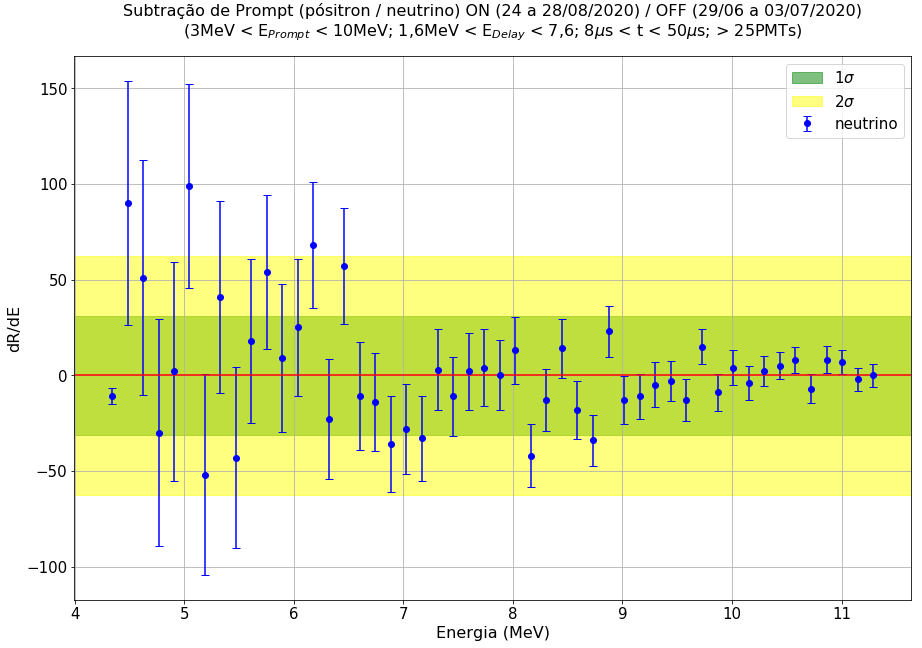

In [52]:
i_day = 5

hg_Sig_OFF = [((x*i_day)**0.5) for x in h_Sig_OFF]
hg_Sig_ON = [((x*i_day)**0.5) for x in h_Sig_ON]

errbar_sigma_day = []
for inf in range(len(hg_Sig_OFF)):
    errbar_sigma_day.append((hg_Sig_OFF[inf]**2 + hg_Sig_ON[inf]**2)**0.5)

#print(bins1_OFF)

fig=plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 15})


hist1_ON, bins1_ON = np.histogram(h_PDP_ON, bins=maxElement)
hist2_ON, bins2_ON = np.histogram(h_PDD_ON, bins=maxElement)
hist3_ON = hist1_ON + hist2_ON

#print(np.amin(bins1_ON))
### E_neutrino = raiz(E_positron^2 + 0,511^2) + 1,3

#print(hist3_ON)

hist1_OFF, bins1_OFF = np.histogram(h_PDP_OFF, bins=maxElement)
hist2_OFF, bins2_OFF = np.histogram(h_PDD_OFF, bins=maxElement)
hist3_OFF = hist1_OFF + hist2_OFF

#print(hist3_OFF)

#diff_hist = hist3_ON - hist3_OFF
diff_hist = hist1_ON - hist1_OFF  # somente com prompt que está relacionado com a energia do neutrino

diff_hist2 = np.append(diff_hist, [0])

print(diff_hist2)
print(np.std(diff_hist2))
#errbar_sigma_day = np.diff(binsd_ON)*histd_ON*sigma_day
#print(errbar_sigma_day)
#errbar_sigma_day = np.append(errbar_sigma_day, [1])

#print(hist2_OFF)
#print(fnt_pe2MeV(bins2_OFF))

#plt.plot(diff_hist,bins=maxElement,histtype='step') ##, bins2_OFF)
#plt.bar(fnt_pe2MeV(bins2_OFF),diff_hist2) ##, bins2_OFF)
## erro de contagem por dia: 23

#plt.errorbar(fnt_pe2MeV(bins1_OFF),diff_hist2, yerr=errbar_sigma_day, marker='o', color='blue', linestyle='None', capsize=4, label='positron')
#plt.errorbar(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF)),diff_hist2, yerr=errbar_sigma_day, marker='o', color='orange', 
#             linestyle='None', capsize=4, label='neutrino')

plt.errorbar(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF)),diff_hist2, yerr=errbar_sigma_day , marker='o', color='blue', 
             linestyle='None', capsize=4, label='neutrino')

plt.grid(True)
plt.axhline(0,color='red')
#plt.axhline(np.std(diff_hist2),color='green')
#plt.axhline(np.std(diff_hist2)*-1,color='green')
#plt.text(4, np.std(diff_hist2), '1sigma') #, ha ='left', va ='center')

#plt.hlines(y = np.std(diff_hist2), xmin = 4, xmax = 12, colors='green', label=r'1$\sigma$') #,alpha=0.5)
#plt.hlines(y = np.std(diff_hist2)*-1, xmin = 4, xmax = 12, colors='green') #,alpha=0.5)

#plt.axhline(np.std(diff_hist2)*2,color='yellow')
#plt.axhline(np.std(diff_hist2)*-2,color='yellow')
#plt.text(4, np.std(diff_hist2)*2, '2sigma') #, ha ='left', va ='center')
#plt.hlines(y = np.std(diff_hist2)*2, xmin = 4, xmax = 12, colors='yellow', label=r'2$\sigma$')
#plt.hlines(y = np.std(diff_hist2)*-2, xmin = 4, xmax = 12, colors='yellow')

plt.axhspan(np.std(diff_hist2), np.std(diff_hist2)*-1, color='green', alpha=0.5, label=r'1$\sigma$')
plt.axhspan(np.std(diff_hist2)*2, np.std(diff_hist2)*-2, color='yellow', alpha=0.5, label=r'2$\sigma$')

#fig, ax = plt.subplots()
#ax.axhspan(np.std(diff_hist2)*2,np.std(diff_hist2)*-2,color='yellow')

plt.legend(loc='upper right')
plt.ylabel('dR/dE', size=16)
plt.xlabel('Energia (MeV)', size=16)
plt.title('Subtração de Prompt (pósitron / neutrino) ON (24 a 28/08/2020) / OFF (29/06 a 03/07/2020)\n'+
          r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; > 25PMTs)', size=16,y=1.02)
          #format(sum(h_PD_pPDF_OFF),int(totalNonSat_OFF)), size=16,y=1.02)
          
plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac.png')
plt.show()

In [1]:
fig=plt.figure(figsize=(12,7))

plt.rcParams.update({'font.size': 15})


hist1_ON, bins1_ON = np.histogram(h_PDP_ON, bins=maxElement)

hist1_OFF, bins1_OFF = np.histogram(h_PDP_OFF, bins=maxElement)

diff_hist = hist1_ON - hist1_OFF  # somente com prompt que está relacionado com a energia do neutrino
diff_hist2 = np.append(diff_hist, [0])

#plt.plot(diff_hist,bins=maxElement,histtype='step') ##, bins2_OFF)
#plt.bar(fnt_pe2MeV(bins2_OFF),diff_hist2) ##, bins2_OFF)
## erro de contagem por dia: 23
print(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF)),hist1_OFF)

#plt.plot(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_ON)),np.insert(hist1_ON,0,hist1_ON[0]), '-', drawstyle='steps') ##, bins2_OFF)

axprops = dict(yticks=[])

axs = []

axs.append(fig.add_axes([0.1, 1.1, 0.8, 0.9], **axprops))
axs.append(fig.add_axes([0.1, 0.5, 0.8, 0.5], **axprops))

#gs = fig.add_gridspec(3, hspace=0)
#axs = gs.subplots(sharex=True, sharey=True)

#axs[0].plot(x, y ** 2)
#axs[1].plot(x, 0.3 * y, 'o')
#axs[2].plot(x, y, '+')
#plt.plot(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_ON[:-1])),hist1_ON, '-', drawstyle='steps', label='ON') ##bins1_ON possui um elemento a mais sempre
#plt.plot(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF[:-1])),hist1_OFF, '-', drawstyle='steps', label='OFF') 

axs[0].plot(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_ON[1:])),hist1_ON, '-', drawstyle='steps', label='ON') ##bins1_ON possui um elemento a mais sempre
axs[0].plot(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF[1:])),hist1_OFF, '-', drawstyle='steps', label='OFF') 
axs[1].errorbar(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF[1:])),diff_hist2[1:], yerr=errbar_sigma_day[1:] , marker='o', color='blue', 
             linestyle='None', capsize=4, label='neutrino')

### acrescentar grid ax0
### titulo em cima
### retirar xticks ax0
### acrescentar yticks ax0 e ax1
### salvar imagem

axs[0].grid(True)
axs[1].grid(True)

#plt.bar(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF)),hist1_OFF) #, color='blue')
axs[1].axhline(0,color='red')

axs[1].axhspan(np.std(diff_hist2), np.std(diff_hist2)*-1, color='green', alpha=0.5, label=r'1$\sigma$')
axs[1].axhspan(np.std(diff_hist2)*2, np.std(diff_hist2)*-2, color='yellow', alpha=0.5, label=r'2$\sigma$')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[0].set_ylabel('dR/dE', size=16)
axs[1].set_xlabel('Energia (MeV)', size=16)
axs[0].set_yticks(np.arange(0, 2500, 200))
axs[1].set_yticks(np.arange(-150, 200, 50))

axs[0].set_title('Subtração de Prompt (pósitron / neutrino) ON (24 a 28/08/2020) / OFF (29/06 a 03/07/2020)\n'+
                 r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; > 25PMTs)', size=16,y=1.02)
          #format(sum(h_PD_pPDF_OFF),int(totalNonSat_OFF)), size=16,y=1.02)
          
plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
plt.show()

NameError: name 'plt' is not defined

In [92]:
print(sum(hist1_ON[:16]))
print(sum(hist1_OFF[:16]))


print(sum(diff_hist2))
print(sum(diff_hist2[:19]))

17675
17320
156
355


### Resultado ON Depois / ON Antes

49
63.13494099538225
[ 33 172 148  33  27 113  88 140 -10  39  90  31  57  51  63  23 -15 -13
 -32  20   2  20  33  34  10  29  13  -9   4  19   3 -15  25  -8   0   1
  14  -5  11   5   4  -4 -13   1   7   1  -8   9  -5   0]
[2.77065728 2.63450704 2.47793427 2.41666667 2.1443662  1.83122066
 1.57934272 1.47042254 1.07558685 1.01431925 1.13004695 1.00751174
 0.79647887 0.65352113 0.62629108 0.60586854 0.43568075 0.35399061
 0.35399061 0.27910798 0.24507042 0.25187793 0.25868545 0.292723
 0.29953052 0.2314554  0.20422535 0.17018779 0.12253521 0.19061033
 0.08169014 0.15657277 0.09530516 0.07488263 0.10211268 0.07488263
 0.03403756 0.04084507 0.04765258 0.04765258 0.03403756 0.04765258
 0.04084507 0.04084507 0.02723005 0.02723005 0.05446009 0.01361502
 0.03403756]


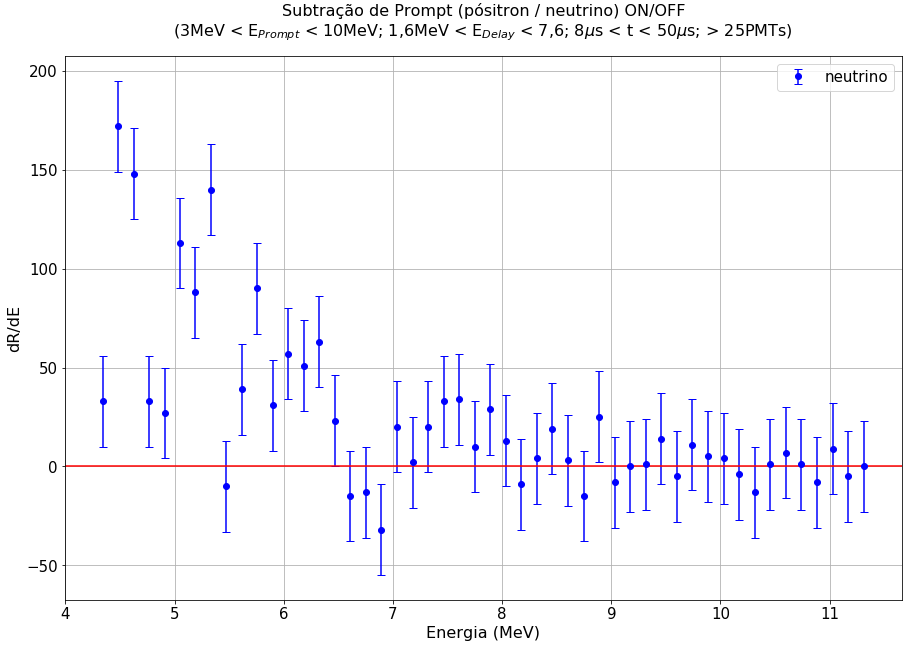

In [25]:

maxElement = int(np.amax(h_PDP_ONA)/5)
print(maxElement)

fig=plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 15})


hist1_ON, bins1_ON = np.histogram(h_PDP_ON, bins=maxElement)
hist2_ON, bins2_ON = np.histogram(h_PDD_ON, bins=maxElement)
hist3_ON = hist1_ON + hist2_ON

print(np.amin(bins1_ON))
### E_neutrino = raiz(E_positron^2 + 0,511^2) + 1,3

#print(hist3_ON)

hist1_ONA, bins1_ONA = np.histogram(h_PDP_ONA, bins=maxElement)
hist2_ONA, bins2_ONA = np.histogram(h_PDD_ONA, bins=maxElement)
hist3_ONA = hist1_ONA + hist2_ONA

diff_hist = hist1_ON - hist1_ONA  # somente com prompt que está relacionado com a energia do neutrino

diff_hist2 = np.append(diff_hist, [0])

print(diff_hist2)
errbar_sigma_day = np.diff(binsd_ON)*histd_ON*sigma_day
print(errbar_sigma_day)
errbar_sigma_day = np.append(errbar_sigma_day, [1])

plt.errorbar(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_ONA)),diff_hist2, yerr=23 , marker='o', color='blue', 
             linestyle='None', capsize=4, label='neutrino')
plt.legend(loc='upper right')
plt.grid(True)
plt.axhline(0,color='red')

plt.ylabel('dR/dE', size=16)
plt.xlabel('Energia (MeV)', size=16)
plt.title('Subtração de Prompt (pósitron / neutrino) ON/OFF\n'+
          r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; > 25PMTs)', size=16,y=1.02)
          
## plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac.png')
plt.show()

In [20]:
print(sum(diff_hist2))
print(sum(diff_hist2[:16]))

430
390


### Resultado OFF / ON Antes

49
63.13494099538225
[ -44  -82  -97  -63  -25  -14 -140  -99  -33  -21  -36  -22  -32   17
  -86   34    4   -1   -4  -48  -35  -17  -44  -32   -6  -29    0  -33
  -17   -5  -21  -19   -2   -5  -11   -6  -17   -8    4  -14    0    0
   15    4    1   -8   16   -2    3    0]
[2.77065728 2.63450704 2.47793427 2.41666667 2.1443662  1.83122066
 1.57934272 1.47042254 1.07558685 1.01431925 1.13004695 1.00751174
 0.79647887 0.65352113 0.62629108 0.60586854 0.43568075 0.35399061
 0.35399061 0.27910798 0.24507042 0.25187793 0.25868545 0.292723
 0.29953052 0.2314554  0.20422535 0.17018779 0.12253521 0.19061033
 0.08169014 0.15657277 0.09530516 0.07488263 0.10211268 0.07488263
 0.03403756 0.04084507 0.04765258 0.04765258 0.03403756 0.04765258
 0.04084507 0.04084507 0.02723005 0.02723005 0.05446009 0.01361502
 0.03403756]


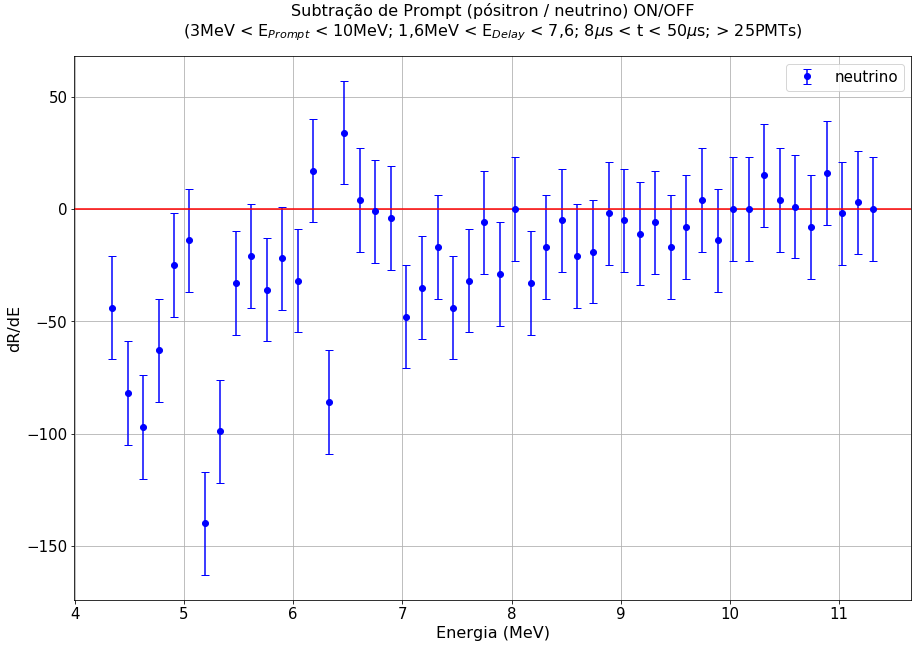

In [45]:

maxElement = int(np.amax(h_PDP_ONA)/5)
print(maxElement)

fig=plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 15})


hist1_OFF, bins1_OFF = np.histogram(h_PDP_OFF, bins=maxElement)
hist2_OFF, bins2_OFF = np.histogram(h_PDD_OFF, bins=maxElement)
hist3_OFF = hist1_OFF + hist2_OFF

print(np.amin(bins1_OFF))
### E_neutrino = raiz(E_positron^2 + 0,511^2) + 1,3

#print(hist3_ON)

hist1_ONA, bins1_ONA = np.histogram(h_PDP_ONA, bins=maxElement)
hist2_ONA, bins2_ONA = np.histogram(h_PDD_ONA, bins=maxElement)
hist3_ONA = hist1_ONA + hist2_ONA

diff_hist = hist1_ONA - hist1_OFF  # somente com prompt que está relacionado com a energia do neutrino

diff_hist2 = np.append(diff_hist, [0])

print(diff_hist2)
errbar_sigma_day = np.diff(binsd_ON)*histd_ON*sigma_day
print(errbar_sigma_day)
errbar_sigma_day = np.append(errbar_sigma_day, [1])

plt.errorbar(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_ONA)),diff_hist2, yerr=23 , marker='o', color='blue', 
             linestyle='None', capsize=4, label='neutrino')
plt.legend(loc='upper right')
plt.grid(True)
plt.axhline(0,color='red')

plt.ylabel('dR/dE', size=16)
plt.xlabel('Energia (MeV)', size=16)
plt.title('Subtração de Prompt (pósitron / neutrino) ON/OFF\n'+
          r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; > 25PMTs)', size=16,y=1.02)
          
## plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac.png')
plt.show()

## Resultado OFF / OFF2

49
63.13494099538225
[ 16  -4 -50 -39 -54   6  83   9  12  14  20  40  25  15  69 -10   9   5
  34  47 -25  14   7  35  17   3   4  29  12  10  12  10  -7  16   7   7
  14   1  -7   6   2  13  -6 -11   3   8  -2 -10  -1   0]
[2.78392362 2.64206764 2.44565166 2.2028597  1.94233573 1.94506373
 1.67771977 1.54950379 1.22896383 1.11165985 1.05164385 0.86886788
 0.76793189 0.7065519  0.60970792 0.57424392 0.43647994 0.41056394
 0.35736795 0.32190396 0.29053196 0.28780396 0.27007196 0.27007196
 0.23051597 0.21141997 0.19232397 0.14867598 0.14867598 0.16640798
 0.11048398 0.09684399 0.12548798 0.08047599 0.08456799 0.07365599
 0.08047599 0.04910399 0.06956399 0.05183199 0.05728799 0.03819199
 0.0341     0.035464   0.04501199 0.030008   0.032736   0.028644
 0.024552  ]


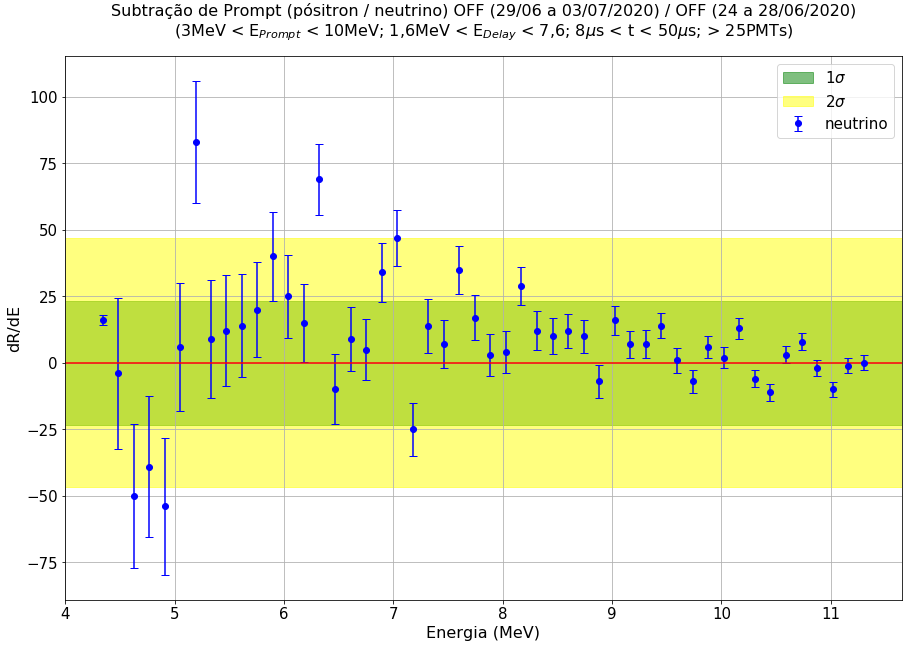

In [107]:
hg_Sig_OFF2 = [(x**0.5) for x in h_Sig_OFF2]
errbar_sigma_day3 = []
for inf in range(len(hg_Sig_OFF2)):
    errbar_sigma_day3.append((hg_Sig_OFF2[inf]**2 + hg_Sig_OFF[inf]**2)**0.5)

maxElement = int(np.amax(h_PDP_OFF2)/5)
print(maxElement)

fig=plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 15})


hist1_OFF, bins1_OFF = np.histogram(h_PDP_OFF, bins=maxElement)
hist2_OFF, bins2_OFF = np.histogram(h_PDD_OFF, bins=maxElement)
hist3_OFF = hist1_OFF + hist2_OFF

print(np.amin(bins1_OFF))
### E_neutrino = raiz(E_positron^2 + 0,511^2) + 1,3

#print(hist3_ON)

hist1_OFF2, bins1_OFF2 = np.histogram(h_PDP_OFF2, bins=maxElement)
hist2_OFF2, bins2_OFF2 = np.histogram(h_PDD_OFF2, bins=maxElement)
hist3_OFF2 = hist1_OFF2 + hist2_OFF2

diff_hist = hist1_OFF - hist1_OFF2  # somente com prompt que está relacionado com a energia do neutrino

diff_hist2 = np.append(diff_hist, [0])

print(diff_hist2)
errbar_sigma_day = np.diff(binsd_ON)*histd_ON*sigma_day
print(errbar_sigma_day)
errbar_sigma_day = np.append(errbar_sigma_day, [1])

plt.errorbar(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF2)),diff_hist2, yerr=errbar_sigma_day3 , marker='o', color='blue', 
             linestyle='None', capsize=4, label='neutrino')

plt.grid(True)
plt.axhline(0,color='red')
#plt.hlines(y = np.std(diff_hist2), xmin = 4, xmax = 12, colors='green', label=r'1$\sigma$') #,alpha=0.5)
#plt.hlines(y = np.std(diff_hist2)*-1, xmin = 4, xmax = 12, colors='green') #,alpha=0.5)
#plt.hlines(y = np.std(diff_hist2)*2, xmin = 4, xmax = 12, colors='yellow', label=r'2$\sigma$')
#plt.hlines(y = np.std(diff_hist2)*-2, xmin = 4, xmax = 12, colors='yellow')
plt.axhspan(np.std(diff_hist2), np.std(diff_hist2)*-1, color='green', alpha=0.5, label=r'1$\sigma$')
plt.axhspan(np.std(diff_hist2)*2, np.std(diff_hist2)*-2, color='yellow', alpha=0.5, label=r'2$\sigma$')


plt.legend(loc='upper right')
plt.ylabel('dR/dE', size=16)
plt.xlabel('Energia (MeV)', size=16)
plt.title('Subtração de Prompt (pósitron / neutrino) OFF (29/06 a 03/07/2020) / OFF (24 a 28/06/2020)\n'+
          r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; > 25PMTs)', size=16,y=1.02)
          
plt.savefig('histogramas/Hist_PD_OFF_X_OFF_Subtrac.png')
plt.show()

In [41]:
print(sum(diff_hist2))
print(sum(diff_hist2[:16]))

593
291


## Resultado ON / OFF2

49
63.13494099538225
[  5  86   1 -69 -52 105  31  50 -31  32  74  49  50  83  46  47  -2  -9
  -2  19 -58  17  -4  37  21   3  17 -13  -1  24  -6 -24  16   3  -4   2
  11 -12   8  -3   6   9  -4  -6  11   1   6  -3  -3   0]
[2.78392362 2.64206764 2.44565166 2.2028597  1.94233573 1.94506373
 1.67771977 1.54950379 1.22896383 1.11165985 1.05164385 0.86886788
 0.76793189 0.7065519  0.60970792 0.57424392 0.43647994 0.41056394
 0.35736795 0.32190396 0.29053196 0.28780396 0.27007196 0.27007196
 0.23051597 0.21141997 0.19232397 0.14867598 0.14867598 0.16640798
 0.11048398 0.09684399 0.12548798 0.08047599 0.08456799 0.07365599
 0.08047599 0.04910399 0.06956399 0.05183199 0.05728799 0.03819199
 0.0341     0.035464   0.04501199 0.030008   0.032736   0.028644
 0.024552  ]


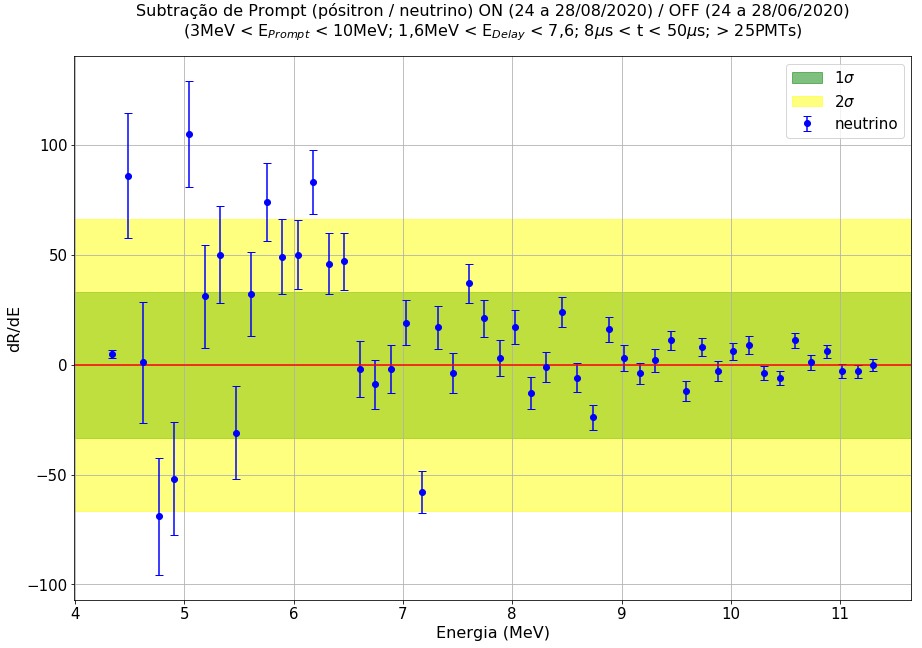

In [103]:
hg_Sig_OFF2 = [(x**0.5) for x in h_Sig_OFF2]
errbar_sigma_day2 = []
for inf in range(len(hg_Sig_OFF2)):
    errbar_sigma_day2.append((hg_Sig_OFF2[inf]**2 + hg_Sig_ON[inf]**2)**0.5)

maxElement = int(np.amax(h_PDP_OFF2)/5)
print(maxElement)

fig=plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 15})


hist1_ON, bins1_ON = np.histogram(h_PDP_ON, bins=maxElement)
hist2_ON, bins2_ON = np.histogram(h_PDD_ON, bins=maxElement)
hist3_ON = hist1_ON + hist2_ON

print(np.amin(bins1_ON))
### E_neutrino = raiz(E_positron^2 + 0,511^2) + 1,3

#print(hist3_ON)

hist1_OFF2, bins1_OFF2 = np.histogram(h_PDP_OFF2, bins=maxElement)
hist2_OFF2, bins2_OFF2 = np.histogram(h_PDD_OFF2, bins=maxElement)
hist3_OFF2 = hist1_OFF2 + hist2_OFF2

#print(hist3_OFF)

#diff_hist = hist3_ON - hist3_OFF
diff_hist = hist1_ON - hist1_OFF2  # somente com prompt que está relacionado com a energia do neutrino

diff_hist2 = np.append(diff_hist, [0])

print(diff_hist2)
errbar_sigma_day = np.diff(binsd_ON)*histd_ON*sigma_day
print(errbar_sigma_day)
errbar_sigma_day = np.append(errbar_sigma_day, [1])
#print(hist2_OFF)
#print(fnt_pe2MeV(bins2_OFF))

#plt.plot(diff_hist,bins=maxElement,histtype='step') ##, bins2_OFF)
#plt.bar(fnt_pe2MeV(bins2_OFF),diff_hist2) ##, bins2_OFF)
## erro de contagem por dia: 23

#plt.errorbar(fnt_pe2MeV(bins1_OFF),diff_hist2, yerr=errbar_sigma_day, marker='o', color='blue', linestyle='None', capsize=4, label='positron')
#plt.errorbar(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF)),diff_hist2, yerr=errbar_sigma_day, marker='o', color='orange', 
#             linestyle='None', capsize=4, label='neutrino')

plt.errorbar(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF2)),diff_hist2, yerr=errbar_sigma_day2 , marker='o', color='blue', 
             linestyle='None', capsize=4, label='neutrino')
plt.grid(True)
plt.axhline(0,color='red')
#plt.hlines(y = np.std(diff_hist2), xmin = 4, xmax = 12, colors='green', label=r'1$\sigma$') #,alpha=0.5)
#plt.hlines(y = np.std(diff_hist2)*-1, xmin = 4, xmax = 12, colors='green') #,alpha=0.5)
#plt.hlines(y = np.std(diff_hist2)*2, xmin = 4, xmax = 12, colors='yellow', label=r'2$\sigma$')
#plt.hlines(y = np.std(diff_hist2)*-2, xmin = 4, xmax = 12, colors='yellow')
plt.axhspan(np.std(diff_hist2), np.std(diff_hist2)*-1, color='green', alpha=0.5, label=r'1$\sigma$')
plt.axhspan(np.std(diff_hist2)*2, np.std(diff_hist2)*-2, color='yellow', alpha=0.5, label=r'2$\sigma$')

plt.legend(loc='upper right')
plt.ylabel('dR/dE', size=16)
plt.xlabel('Energia (MeV)', size=16)
plt.title('Subtração de Prompt (pósitron / neutrino) ON (24 a 28/08/2020) / OFF (24 a 28/06/2020)\n'+
          r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; > 25PMTs)', size=16,y=1.02)
          #format(sum(h_PD_pPDF_OFF),int(totalNonSat_OFF)), size=16,y=1.02)
          
plt.savefig('histogramas/Hist_PD_ON_X_OFF2_Subtrac.png')
plt.show()

In [43]:
print(sum(diff_hist2))
print(sum(diff_hist2[:16]))

749
646


## Potencia do reator

In [8]:
file='neutrinos_parada_2020.csv'
df_OFF = pd.read_csv(file, sep=';', decimal=',')
#df_OFF.to_parquet(file)

print(df_OFF)
        

                Data_Hora  Pot_Gerador_MW  Pot_Reator_MW
0              16/06/2020      1147.64001     3264.73706
1     16/06/2020 00:10:00      1147.89905     3253.06592
2     16/06/2020 00:20:00      1147.64001     3238.51611
3     16/06/2020 00:30:00      1148.15906     3256.04102
4     16/06/2020 00:40:00      1148.41797     3247.87988
5     16/06/2020 00:50:00      1148.80701     3265.22607
6     16/06/2020 01:00:00      1148.67700     3251.22803
7     16/06/2020 01:10:00      1147.25000     3260.56299
8     16/06/2020 01:20:00      1148.54797     3252.98291
9     16/06/2020 01:30:00      1148.02905     3251.05005
10    16/06/2020 01:40:00      1148.15906     3246.35596
11    16/06/2020 01:50:00      1148.28796     3265.11206
12    16/06/2020 02:00:00      1148.15906     3242.58789
13    16/06/2020 02:10:00      1148.28796     3237.36694
14    16/06/2020 02:20:00      1148.41797     3236.29004
15    16/06/2020 02:30:00      1148.15906     3270.21997
16    16/06/2020 02:40:00      

In [9]:
file='neutrinos_partida_2020.csv'
df_ON = pd.read_csv(file, sep=';', decimal=',')
#df_OFF.to_parquet(file)

print(df_ON)

                Data_Hora  Pot_Gerador_MW  Pot_Reator_MW
0              16/08/2020         2.59471       56.59520
1     16/08/2020 00:10:00         2.72444       56.69610
2     16/08/2020 00:20:00         2.72444       57.10376
3     16/08/2020 00:30:00         2.72444       57.40477
4     16/08/2020 00:40:00         2.72444       57.61824
5     16/08/2020 00:50:00         2.72444       57.20861
6     16/08/2020 01:00:00         2.72444       58.82925
7     16/08/2020 01:10:00         2.72444       58.62350
8     16/08/2020 01:20:00         2.72444       58.62924
9     16/08/2020 01:30:00         2.59471       58.92705
10    16/08/2020 01:40:00         2.59471       57.92161
11    16/08/2020 01:50:00         2.59471       58.83161
12    16/08/2020 02:00:00         2.72444       59.04151
13    16/08/2020 02:10:00         2.72444       59.24284
14    16/08/2020 02:20:00         2.72444       59.94746
15    16/08/2020 02:30:00         2.72444       60.15049
16    16/08/2020 02:40:00      

In [13]:
h_days_reactor = [x for x in range(len(df_OFF)+(6*24*54)+len(df_ON))]
h_pot_reactor = []

h_pot_zero = [0 for x in range(6*24*54)]

#h_days_reactor.extend(df_OFF['Data_Hora'].values)
#h_days_reactor.extend(df_ON['Data_Hora'].values)

h_pot_reactor.extend(df_OFF['Pot_Reator_MW'].values)
h_pot_reactor.extend([0 for x in range(6*24*54)])
h_pot_reactor.extend(df_ON['Pot_Reator_MW'].values)


In [11]:
'''
h_days_reactor = []
h_days_reactor.extend(df_OFF['Data_Hora'].values)
h_days_reactor.extend(df_ON['Data_Hora'].values)
h_pot_reactor = []
h_pot_reactor.extend(df_OFF['Pot_Reator_MW'].values)
h_pot_reactor.extend(df_ON['Pot_Reator_MW'].values)
'''

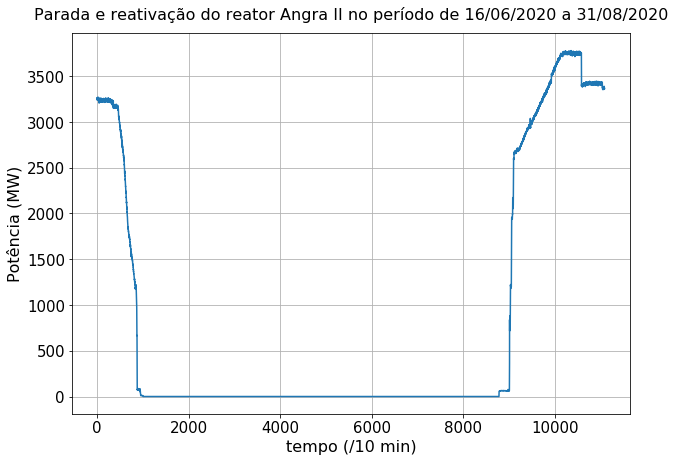

In [14]:
fig=plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 15})


plt.plot(h_days_reactor,h_pot_reactor)

plt.grid(True)

plt.ylabel('Potência (MW)', size=16)
plt.xlabel('tempo (/10 min)', size=16)
plt.title('Parada e reativação do reator Angra II no período de 16/06/2020 a 31/08/2020', size=16,y=1.02)
          
plt.savefig('histogramas/Reabastecimento_Reator.png')
plt.show()

## Processamento OFF3

In [8]:
print('Inicio',datetime.datetime.now())

h_PDP_OFF3 = []
h_PDD_OFF3 = []
h_PDT_OFF3 = []
h_PD_pPDF_OFF3 = []
totalPositrons_OFF3 = 0
totalNonSat_OFF3 = 0
                            
totalPositrons_OFF3, totalNonSat_OFF3, h_Sig_OFF3, h_SigR_OFF3, h_Std_OFF3 = fnt_process_list_PD(list_OFF3, h_PDP_OFF3, h_PDD_OFF3, h_PDT_OFF3, h_PD_pPDF_OFF3, bins_interval)
                            
#print(len(h_P_ON))
#print(len(h_D_ON))
print(len(h_PDP_OFF3))
print(len(h_PDD_OFF3))
print(len(h_PDT_OFF3))
print('Em 5 dias: ',totalPositrons_OFF3)
print('Por dia: ',totalPositrons_OFF3/5)
print('Em Hz: ',totalPositrons_OFF3/5/86400) 
print('Em 5 dias (NS): ',totalNonSat_OFF3)
print('Por dia (NS): ',totalNonSat_OFF3/5)
print('Em Hz (NS): ',totalNonSat_OFF3/5/86400) 

        
print('Fim',datetime.datetime.now())

Inicio 2023-03-27 00:46:39.174293
data/20200704
calculando bin
data/20200705
calculando bin
data/20200706
calculando bin
data/20200707
calculando bin
data/20200708
calculando bin
calculando sigmas
21468
21468
21468
Em 5 dias:  82537526
Por dia:  16507505.2
Em Hz:  191.05908796296296
Em 5 dias (NS):  53072486
Por dia (NS):  10614497.2
Em Hz (NS):  122.85297685185185
Fim 2023-03-27 01:10:31.161886


## Processamento OFF4

In [9]:
print('Inicio',datetime.datetime.now())

h_PDP_OFF4 = []
h_PDD_OFF4 = []
h_PDT_OFF4 = []
h_PD_pPDF_OFF4 = []
totalPositrons_OFF4 = 0
totalNonSat_OFF4 = 0
                            
totalPositrons_OFF4, totalNonSat_OFF4, h_Sig_OFF4, h_SigR_OFF4, h_Std_OFF4 = fnt_process_list_PD(list_OFF4, h_PDP_OFF4, h_PDD_OFF4, h_PDT_OFF4, h_PD_pPDF_OFF4, bins_interval)
                            
#print(len(h_P_ON))
#print(len(h_D_ON))
print(len(h_PDP_OFF4))
print(len(h_PDD_OFF4))
print(len(h_PDT_OFF4))
print('Em 5 dias: ',totalPositrons_OFF4)
print('Por dia: ',totalPositrons_OFF4/5)
print('Em Hz: ',totalPositrons_OFF4/5/86400) 
print('Em 5 dias (NS): ',totalNonSat_OFF4)
print('Por dia (NS): ',totalNonSat_OFF4/5)
print('Em Hz (NS): ',totalNonSat_OFF4/5/86400) 

        
print('Fim',datetime.datetime.now())

Inicio 2023-03-27 01:10:32.066034
data/20200709
calculando bin
data/20200710
calculando bin


C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\RetailAdmin\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data/20200711
calculando bin
data/20200712
calculando bin
data/20200713
calculando bin
calculando sigmas
21313
21313
21313
Em 5 dias:  82880896
Por dia:  16576179.2
Em Hz:  191.85392592592592
Em 5 dias (NS):  53741610
Por dia (NS):  10748322.0
Em Hz (NS):  124.401875
Fim 2023-03-27 01:34:33.376178


## Processamento OFF5

In [10]:
print('Inicio',datetime.datetime.now())

h_PDP_OFF5 = []
h_PDD_OFF5 = []
h_PDT_OFF5 = []
h_PD_pPDF_OFF5 = []
totalPositrons_OFF5 = 0
totalNonSat_OFF5 = 0
                            
totalPositrons_OFF5, totalNonSat_OFF5, h_Sig_OFF5, h_SigR_OFF5, h_Std_OFF5 = fnt_process_list_PD(list_OFF5, h_PDP_OFF5, h_PDD_OFF5, h_PDT_OFF5, h_PD_pPDF_OFF5, bins_interval)
                            
#print(len(h_P_ON))
#print(len(h_D_ON))
print(len(h_PDP_OFF5))
print(len(h_PDD_OFF5))
print(len(h_PDT_OFF5))
print('Em 5 dias: ',totalPositrons_OFF5)
print('Por dia: ',totalPositrons_OFF5/5)
print('Em Hz: ',totalPositrons_OFF5/5/86400) 
print('Em 5 dias (NS): ',totalNonSat_OFF5)
print('Por dia (NS): ',totalNonSat_OFF5/5)
print('Em Hz (NS): ',totalNonSat_OFF5/5/86400) 

        
print('Fim',datetime.datetime.now())

Inicio 2023-03-27 09:38:59.712255
data/20200714
calculando bin
data/20200715
calculando bin
data/20200716
calculando bin
data/20200717
calculando bin
data/20200718
calculando bin
calculando sigmas
19996
19996
19996
Em 5 dias:  80618517
Por dia:  16123703.4
Em Hz:  186.6169375
Em 5 dias (NS):  51827594
Por dia (NS):  10365518.8
Em Hz (NS):  119.97128240740741
Fim 2023-03-27 10:06:10.299228


## Processamento OFF6

In [11]:
print('Inicio',datetime.datetime.now())

h_PDP_OFF6 = []
h_PDD_OFF6 = []
h_PDT_OFF6 = []
h_PD_pPDF_OFF6 = []
totalPositrons_OFF6 = 0
totalNonSat_OFF6 = 0
                            
totalPositrons_OFF6, totalNonSat_OFF6, h_Sig_OFF6, h_SigR_OFF6, h_Std_OFF6 = fnt_process_list_PD(list_OFF6, h_PDP_OFF6, h_PDD_OFF6, h_PDT_OFF6, h_PD_pPDF_OFF6, bins_interval)
                            
#print(len(h_P_ON))
#print(len(h_D_ON))
print(len(h_PDP_OFF6))
print(len(h_PDD_OFF6))
print(len(h_PDT_OFF6))
print('Em 5 dias: ',totalPositrons_OFF6)
print('Por dia: ',totalPositrons_OFF6/5)
print('Em Hz: ',totalPositrons_OFF6/5/86400) 
print('Em 5 dias (NS): ',totalNonSat_OFF6)
print('Por dia (NS): ',totalNonSat_OFF6/5)
print('Em Hz (NS): ',totalNonSat_OFF6/5/86400) 

        
print('Fim',datetime.datetime.now())

Inicio 2023-03-27 10:06:14.234427
data/20200719
calculando bin
data/20200720
calculando bin
data/20200721
calculando bin
data/20200722
calculando bin
data/20200723
calculando bin
calculando sigmas
20494
20494
20494
Em 5 dias:  82121913
Por dia:  16424382.6
Em Hz:  190.09702083333332
Em 5 dias (NS):  52928321
Por dia (NS):  10585664.2
Em Hz (NS):  122.51926157407406
Fim 2023-03-27 10:34:32.625650


## Salvar e carregar Listas ON / OFF

In [6]:
##save values - h_Sig_OFF2 (contém o sigma de cada bin dividido por 5dias)
def save_PD (dh_PDP, dh_PDD, dh_PDT, dh_Sig, sName):
    # dictionary of lists
    dict = {'dh_PDP': dh_PDP,
            'dh_PDD': dh_PDD,
            'dh_PDT': dh_PDT}
    
    dict2 = {'dh_Sig': dh_Sig}
 
    # creating a dataframe from dictionary
    dfw = pd.DataFrame(dict)
    dfw.to_parquet('data/Analise_ONOFF/'+sName+'.parq', compression='gzip')

    dfw2 = pd.DataFrame(dict2)
    dfw2.to_parquet('data/Analise_ONOFF/Sig_'+sName+'.parq', compression='gzip')

    del dict2
    del dict
    
##load values
def load_PD (sName): #(dh_PDP, dh_PDD, dh_PDT, dh_Sig, sName):
    dfr = pd.read_parquet('data/Analise_ONOFF/'+sName+'.parq')
    dfr2 = pd.read_parquet('data/Analise_ONOFF/Sig_'+sName+'.parq')
    return(dfr['dh_PDP'].values, dfr['dh_PDD'].values, dfr['dh_PDT'].values, dfr2['dh_Sig'].values)

    

In [22]:
i_day = 5

hg_Sig_ON = [((x*i_day)**0.5) for x in h_Sig_ON]     ## x é a quantidade do bin / quantidade de dias 
hg_Sig_OFF = [((x*i_day)**0.5) for x in h_Sig_OFF]   ## para chegar ao desvio padrão, fazemos quantidade do bin * qtde dias
hg_Sig_OFF2 = [((x*i_day)**0.5) for x in h_Sig_OFF2] ## para restaurar a quantidade do bin e tiramos a raiz quadrada
hg_Sig_OFF3 = [((x*i_day)**0.5) for x in h_Sig_OFF3] ## isso será o sigma do bin, de acordo com Distrib Poisson (ver Melissinos)
hg_Sig_OFF4 = [((x*i_day)**0.5) for x in h_Sig_OFF4] ## 21/04/2023
hg_Sig_OFF5 = [((x*i_day)**0.5) for x in h_Sig_OFF5] ## no caso i_day=5 a quantidade do bin possui a contagem de energia
hg_Sig_OFF6 = [((x*i_day)**0.5) for x in h_Sig_OFF6] ## dos 5 dias 

print(len(hg_Sig_ON), len(h_PDP_ON))

50 21261


In [19]:
i_day = 30

hg_Sig_ON = [((x*i_day)**0.5) for x in h_Sig_ON]     ## x é a quantidade do bin / quantidade de dias 
hg_Sig_OFF = [((x*i_day)**0.5) for x in h_Sig_OFF] 

In [23]:
# save_PD (h_PDP_ON, h_PDP_ON, h_PDP_ON, hg_Sig_ON, 'PD_ON') ## estava errado, não salvei PDD e PDT
save_PD (h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON, 'PD_ON')
save_PD (h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF, 'PD_OFF')
save_PD (h_PDP_OFF2, h_PDD_OFF2, h_PDT_OFF2, hg_Sig_OFF2, 'PD_OFF2')
save_PD (h_PDP_OFF3, h_PDD_OFF3, h_PDT_OFF3, hg_Sig_OFF3, 'PD_OFF3')
save_PD (h_PDP_OFF4, h_PDD_OFF4, h_PDT_OFF4, hg_Sig_OFF4, 'PD_OFF4')
save_PD (h_PDP_OFF5, h_PDD_OFF5, h_PDT_OFF5, hg_Sig_OFF5, 'PD_OFF5')
save_PD (h_PDP_OFF6, h_PDD_OFF6, h_PDT_OFF6, hg_Sig_OFF6, 'PD_OFF6')

In [20]:
save_PD (h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON, 'PD_ON_30')
save_PD (h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF, 'PD_OFF_30')


In [74]:
save_PD (h_PDP_ON2, h_PDD_ON2, h_PDT_ON2, hg_Sig_ON2, 'PD_ON2_30')


In [11]:
save_PD (h_PDP_ON3, h_PDD_ON3, h_PDT_ON3, hg_Sig_ON3, 'PD_ON3_30')

In [21]:
save_PD (h_PDP_ON4, h_PDD_ON4, h_PDT_ON4, hg_Sig_ON4, 'PD_ON4_30')

In [9]:
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON')
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF')
h_PDP_OFF2, h_PDD_OFF2, h_PDT_OFF2, hg_Sig_OFF2 = load_PD ( 'PD_OFF2')
h_PDP_OFF3, h_PDD_OFF3, h_PDT_OFF3, hg_Sig_OFF3 = load_PD ( 'PD_OFF3')
h_PDP_OFF4, h_PDD_OFF4, h_PDT_OFF4, hg_Sig_OFF4 = load_PD ( 'PD_OFF4')
h_PDP_OFF5, h_PDD_OFF5, h_PDT_OFF5, hg_Sig_OFF5 = load_PD ( 'PD_OFF5')
h_PDP_OFF6, h_PDD_OFF6, h_PDT_OFF6, hg_Sig_OFF6 = load_PD ( 'PD_OFF6')

In [5]:
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON_30')
h_PDP_ON2, h_PDD_ON2, h_PDT_ON2, hg_Sig_ON2 = load_PD ( 'PD_ON2_30')
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF_30')

In [9]:
h_PDP_ONT=[]
h_PDD_ONT=[]
h_PDT_ONT=[]
hg_Sig_ONT=[]

h_PDP_ONT, h_PDP_ONT, h_PDP_ONT, hg_Sig_ONT = load_PD ('PD_ON')

In [17]:
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON_30')
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF_30')

In [21]:
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON_30_m10')
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF_30_m10')

In [14]:
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON_30_m0')
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF_30_m0')

## Plot genérico por atribuição

In [22]:
i_day = 5
#histd_ON, binsd_ON = np.histogram(h_PDP_ON, bins=maxElement, normed= True)


## gnh_PDP_ON: primeiro set genérico de valores (pode ser um set OFF)
#gnh_PDP_ON = h_PDP_OFF
#gnh_Sig_ON = hg_Sig_OFF #[((x*i_day)**0.5) for x in hg_Sig_ON]
gnh_PDP_ON = h_PDP_ON
gnh_Sig_ON = hg_Sig_ON #[((x*i_day)**0.5) for x in hg_Sig_ON]

#ls_dataI = list_OFF[0]
#ls_dataF = list_OFF[4]
ls_dataI = list_ON[0]
ls_dataF = list_ON[29]

tl_set1 = 'ON2 ('+ls_dataI[6:8]+'/'+ls_dataI[4:6]+'/'+ls_dataI[0:4]+' a '+ls_dataF[6:8]+'/'+ls_dataF[4:6]+'/'+ls_dataF[0:4]+')'
print(tl_set1)

## gnh_PDP_ON: segundo set genérico de valores que será retirado do primeiro (pode ser outro set OFF)
gnh_PDP_OFF = h_PDP_OFF
gnh_Sig_OFF = hg_Sig_OFF #[((x*i_day)**0.5) for x in hg_Sig_OFF5]
#gnh_PDP_OFF = h_PDP_OFF
#gnh_Sig_OFF = hg_Sig_OFF #[((x*i_day)**0.5) for x in hg_Sig_OFF5]

#ls_dataI = list_OFF6[0]
#ls_dataF = list_OFF6[4]
ls_dataI = list_OFF[0]
ls_dataF = list_OFF[29]

tl_set2 = 'OFF ('+ls_dataI[6:8]+'/'+ls_dataI[4:6]+'/'+ls_dataI[0:4]+' a '+ls_dataF[6:8]+'/'+ls_dataF[4:6]+'/'+ls_dataF[0:4]+')'
print(tl_set2)

maxElement = int(np.amax(gnh_PDP_OFF)/5)

errbar_sigma_day = []
for inf in range(len(gnh_Sig_OFF)):
    errbar_sigma_day.append((gnh_Sig_OFF[inf]**2 + gnh_Sig_ON[inf]**2)**0.5)


ON2 (20/08/2020 a 28/09/2020)
OFF (24/06/2020 a 23/07/2020)


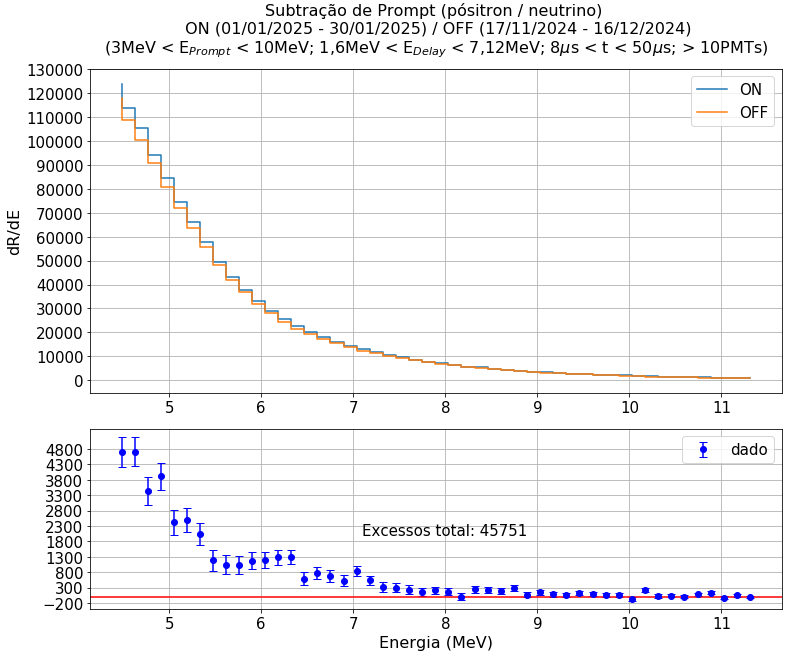

Excessos total
45751
Excessos até 7MeV
40775
Excessos até 6,5MeV
38792


In [23]:


fig=plt.figure(figsize=(12,5))

plt.rcParams.update({'font.size': 15})

maxElement = int(np.amax(h_PDP_OFF)/5)
gnh_Sig_ON = hg_Sig_ON #[((x*i_day)**0.5) for x in hg_Sig_ON]
gnh_Sig_OFF = hg_Sig_OFF #[((x*i_day)**0.5) for x in hg_Sig_ON]

#errbar_sigma_day = []
#for inf in range(len(gnh_Sig_OFF)):
#    errbar_sigma_day.append((gnh_Sig_OFF[inf]**2 + gnh_Sig_ON[inf]**2)**0.5)
    
hist1_ON, bins1_ON = np.histogram(h_PDP_ON, bins=maxElement)
hist1_OFF, bins1_OFF = np.histogram(h_PDP_OFF, bins=maxElement)

diff_hist = hist1_ON - hist1_OFF  # somente com prompt que está relacionado com a energia do neutrino
diff_hist2 = np.append(diff_hist, [0])

errbar_sigma_day = []
for inf in range(len(hist1_ON)):
    errbar_sigma_day.append((hist1_ON[inf] + hist1_OFF[inf])**0.5)


#print(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF)),hist1_OFF)

axprops = dict(yticks=[])
axs = []

axs.append(fig.add_axes([0.1, 1.1, 0.8, 0.9], **axprops))
axs.append(fig.add_axes([0.1, 0.5, 0.8, 0.5], **axprops))

axs[0].plot(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_ON[1:])),hist1_ON, '-', drawstyle='steps', label='ON') ##bins1_ON possui um elemento a mais sempre
axs[0].plot(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF[1:])),hist1_OFF, '-', drawstyle='steps', label='OFF') 
#axs[1].errorbar(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF[1:])),diff_hist2[1:], yerr=errbar_sigma_day[1:] , marker='o', color='blue', 
#             linestyle='None', capsize=4, label='dado')
axs[1].errorbar(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF[1:])),diff_hist2[1:], yerr=errbar_sigma_day, #[1:] , 
                marker='o', color='blue', 
                linestyle='None', capsize=4, label='dado')

axs[0].grid(True)
axs[1].grid(True)

axs[1].axhline(0,color='red')

#axs[1].axhspan(np.std(diff_hist2), np.std(diff_hist2)*-1, color='green', alpha=0.5, label=r'1$\sigma$')
#axs[1].axhspan(np.std(diff_hist2)*2, np.std(diff_hist2)*-2, color='yellow', alpha=0.5, label=r'2$\sigma$')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[0].set_ylabel('dR/dE', size=16)
axs[1].set_xlabel('Energia (MeV)', size=16)
axs[0].set_yticks(np.arange(0, 140000, 10000))
axs[1].set_yticks(np.arange(-200, 5000, 500))
#axs[0].set_yticks(np.arange(0, 30000, 10000))
#axs[1].set_yticks(np.arange(-200, 800, 200))

tl_set1 = 'ON (01/01/2025 - 30/01/2025)'
tl_set2 = 'OFF (17/11/2024 - 16/12/2024)'

axs[0].set_title('Subtração de Prompt (pósitron / neutrino) \n '+
                 tl_set1+' / '+
                 tl_set2+'\n'+
                 r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; > 10PMTs)', size=16,y=1.02)

axs[1].annotate('Excessos total: {:d}'.format(sum(diff_hist2)), xy=(7.1, 2000))
#plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
plt.show()

print('Excessos total')
print(sum(diff_hist2))
print('Excessos até 7MeV')
print(sum(diff_hist2[:19]))
print('Excessos até 6,5MeV')
print(sum(diff_hist2[:16]))


## Plot ON4 / OFF 

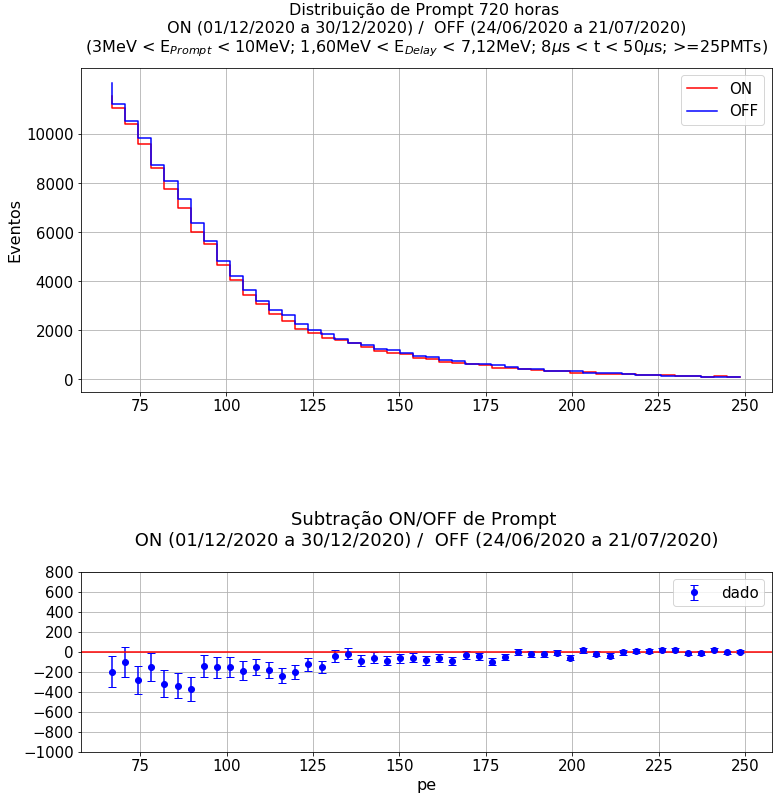

Excessos total
-5011
Excessos até 7MeV
-4050
Excessos até 6,5MeV
-3728


In [22]:
fig=plt.figure(figsize=(12,5))

plt.rcParams.update({'font.size': 15})

maxElement = int(np.amax(h_PDP_ON4)/5)

hist_ON4, bins_ON4 = np.histogram(h_PDP_ON4, bins=maxElement)
hist_OFF, bins_OFF = np.histogram(h_PDP_OFF, bins=maxElement)


hist_OND_A, bins_OND_all = np.histogram(h_PDP_ON4, bins=maxElement)
hist_OFF_A, bins_OFF_all = np.histogram(h_PDP_OFF, bins=maxElement)

diff_hist = hist_OND_A - hist_OFF_A  # somente com prompt que está relacionado com a energia do neutrino
diff_hist2 = np.append(diff_hist, [0])

errbar_sigma_day = []
for inf in range(len(hist_OND_A)):
    errbar_sigma_day.append((hist_OND_A[inf] + hist_OFF_A[inf])**0.5)


axprops = dict(yticks=[])
axs = []

axs.append(fig.add_axes([0.1, 1.0, 0.8, 0.9], **axprops))
axs.append(fig.add_axes([0.1, 0, 0.8, 0.5], **axprops))

axs[0].plot(bins_ON4[1:],hist_ON4, '-', drawstyle='steps', color='red', label='ON') ##bins_ON possui um elemento a mais sempre
axs[0].plot(bins_OFF[1:],hist_OFF, '-', drawstyle='steps', color='blue', label='OFF') 
axs[1].errorbar(bins_OFF[1:],diff_hist2[1:], yerr=errbar_sigma_day, #[1:] , 
                marker='o', color='blue', 
                linestyle='None', capsize=4, label='dado')

axs[0].grid(True)
axs[1].grid(True)

axs[1].axhline(0,color='red')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[0].set_ylabel('Eventos', size=16)
axs[1].set_xlabel('pe', size=16)
axs[0].set_yticks(np.arange(0, hist_ON4[0],2000))
axs[1].set_yticks(np.arange(-1000, 1000, 200))

axs[0].set_title('Distribuição de Prompt 720 horas \n '+
                 'ON (01/12/2020 a 30/12/2020) / '+
                 ' OFF (24/06/2020 a 21/07/2020) \n'+
                 r'(3MeV < E$_{Prompt}$ < 10MeV; 1,60MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; >=25PMTs)', size=16,y=1.02)
axs[1].set_title('Subtração ON/OFF de Prompt \n '+
                 'ON (01/12/2020 a 30/12/2020) / '+
                 ' OFF (24/06/2020 a 21/07/2020) \n')

#plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
plt.show()

print('Excessos total')
print(sum(diff_hist2))
print('Excessos até 7MeV')
print(sum(diff_hist2[:19]))
print('Excessos até 6,5MeV')
print(sum(diff_hist2[:16]))

## Plot ON3 / OFF 

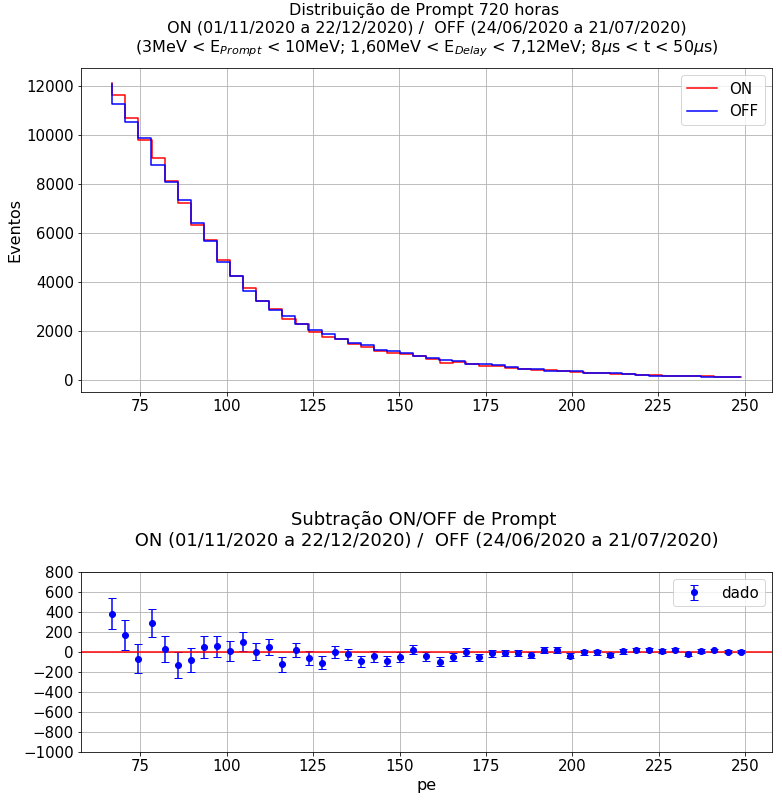

Excessos total
18
Excessos até 7MeV
608
Excessos até 6,5MeV
782


In [13]:

fig=plt.figure(figsize=(12,5))

plt.rcParams.update({'font.size': 15})

maxElement = int(np.amax(h_PDP_ON3)/5)

hist_ON3, bins_ON3 = np.histogram(h_PDP_ON3, bins=maxElement)
hist_OFF, bins_OFF = np.histogram(h_PDP_OFF, bins=maxElement)


hist_ONO_A, bins_ONO_all = np.histogram(h_PDP_ON3, bins=maxElement)
hist_OFF_A, bins_OFF_all = np.histogram(h_PDP_OFF, bins=maxElement)

diff_hist = hist_ONO_A - hist_OFF_A  # somente com prompt que está relacionado com a energia do neutrino
diff_hist2 = np.append(diff_hist, [0])

errbar_sigma_day = []
for inf in range(len(hist_ONO_A)):
    errbar_sigma_day.append((hist_ONO_A[inf] + hist_OFF_A[inf])**0.5)


axprops = dict(yticks=[])
axs = []

axs.append(fig.add_axes([0.1, 1.0, 0.8, 0.9], **axprops))
axs.append(fig.add_axes([0.1, 0, 0.8, 0.5], **axprops))

axs[0].plot(bins_ON3[1:],hist_ON3, '-', drawstyle='steps', color='red', label='ON') ##bins_ON possui um elemento a mais sempre
axs[0].plot(bins_OFF[1:],hist_OFF, '-', drawstyle='steps', color='blue', label='OFF') 
axs[1].errorbar(bins_OFF[1:],diff_hist2[1:], yerr=errbar_sigma_day, #[1:] , 
                marker='o', color='blue', 
                linestyle='None', capsize=4, label='dado')

axs[0].grid(True)
axs[1].grid(True)

axs[1].axhline(0,color='red')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[0].set_ylabel('Eventos', size=16)
axs[1].set_xlabel('pe', size=16)
axs[0].set_yticks(np.arange(0, hist_ON3[0],2000))
axs[1].set_yticks(np.arange(-1000, 1000, 200))

axs[0].set_title('Distribuição de Prompt 720 horas \n '+
                 'ON (01/11/2020 a 30/11/2020) / '+
                 ' OFF (24/06/2020 a 21/07/2020) \n'+
                 r'(3MeV < E$_{Prompt}$ < 10MeV; 1,60MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; >=25PMTs)', size=16,y=1.02)
axs[1].set_title('Subtração ON/OFF de Prompt \n '+
                 'ON (01/11/2020 a 30/11/2020) / '+
                 ' OFF (24/06/2020 a 21/07/2020) \n')

#plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
plt.show()

print('Excessos total')
print(sum(diff_hist2))
print('Excessos até 7MeV')
print(sum(diff_hist2[:19]))
print('Excessos até 6,5MeV')
print(sum(diff_hist2[:16]))

## Plot ON2 / OFF 

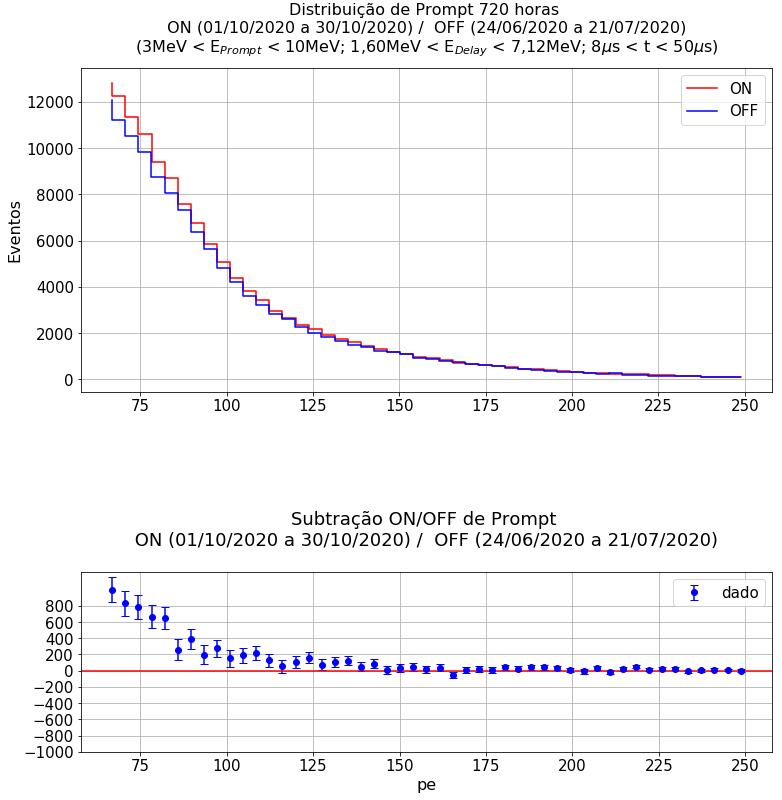

Excessos total
7668
Excessos até 7MeV
6960
Excessos até 6,5MeV
6622


In [18]:
fig=plt.figure(figsize=(12,5))

plt.rcParams.update({'font.size': 15})

maxElement = int(np.amax(h_PDP_ON2)/5)

hist_ON3, bins_ON3 = np.histogram(h_PDP_ON2, bins=maxElement)
hist_OFF, bins_OFF = np.histogram(h_PDP_OFF, bins=maxElement)


hist_ONO_A, bins_ONO_all = np.histogram(h_PDP_ON2, bins=maxElement)
hist_OFF_A, bins_OFF_all = np.histogram(h_PDP_OFF, bins=maxElement)

diff_hist = hist_ONO_A - hist_OFF_A  # somente com prompt que está relacionado com a energia do neutrino
diff_hist2 = np.append(diff_hist, [0])

errbar_sigma_day = []
for inf in range(len(hist_ONO_A)):
    errbar_sigma_day.append((hist_ONO_A[inf] + hist_OFF_A[inf])**0.5)


axprops = dict(yticks=[])
axs = []

axs.append(fig.add_axes([0.1, 1.0, 0.8, 0.9], **axprops))
axs.append(fig.add_axes([0.1, 0, 0.8, 0.5], **axprops))

axs[0].plot(bins_ON3[1:],hist_ON3, '-', drawstyle='steps', color='red', label='ON') ##bins_ON possui um elemento a mais sempre
axs[0].plot(bins_OFF[1:],hist_OFF, '-', drawstyle='steps', color='blue', label='OFF') 
axs[1].errorbar(bins_OFF[1:],diff_hist2[1:], yerr=errbar_sigma_day, #[1:] , 
                marker='o', color='blue', 
                linestyle='None', capsize=4, label='dado')

axs[0].grid(True)
axs[1].grid(True)

axs[1].axhline(0,color='red')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[0].set_ylabel('Eventos', size=16)
axs[1].set_xlabel('pe', size=16)
axs[0].set_yticks(np.arange(0, hist_ON3[0],2000))
axs[1].set_yticks(np.arange(-1000, 1000, 200))

axs[0].set_title('Distribuição de Prompt 720 horas \n '+
                 'ON (01/10/2020 a 30/10/2020) / '+
                 ' OFF (24/06/2020 a 21/07/2020) \n'+
                 r'(3MeV < E$_{Prompt}$ < 10MeV; 1,60MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; >=25PMTs)', size=16,y=1.02)
axs[1].set_title('Subtração ON/OFF de Prompt \n '+
                 'ON (01/10/2020 a 30/10/2020) / '+
                 ' OFF (24/06/2020 a 21/07/2020) \n')

#plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
plt.show()

print('Excessos total')
print(sum(diff_hist2))
print('Excessos até 7MeV')
print(sum(diff_hist2[:19]))
print('Excessos até 6,5MeV')
print(sum(diff_hist2[:16]))

## Plot ON / OFF

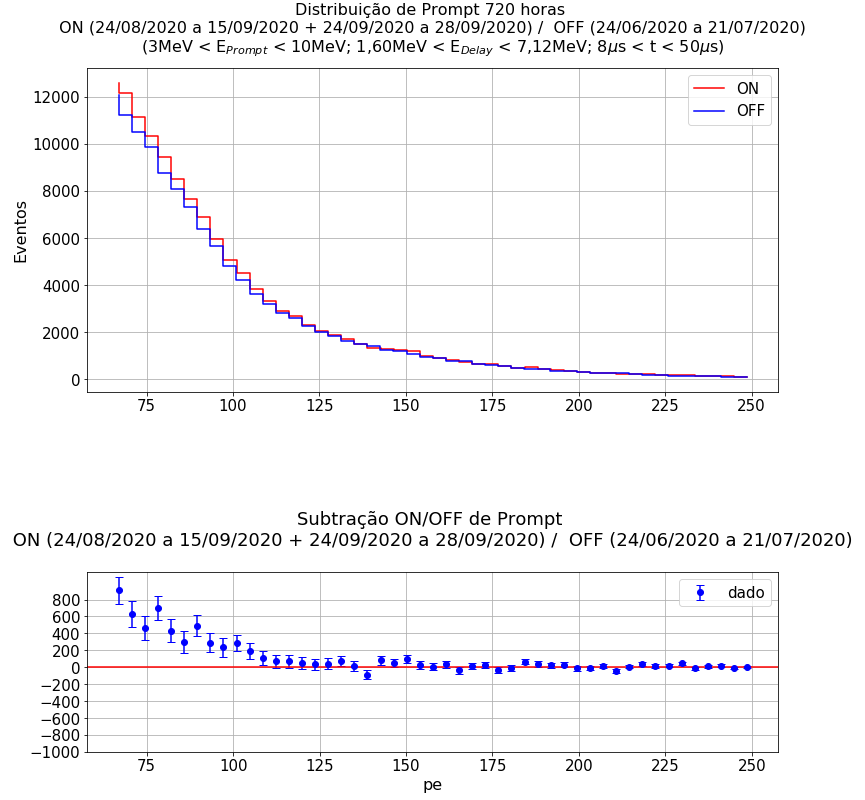

Excessos total
6302
Excessos até 7MeV
5880
Excessos até 6,5MeV
5739


In [19]:
fig=plt.figure(figsize=(12,5))

plt.rcParams.update({'font.size': 15})

maxElement = int(np.amax(h_PDP_ON)/5)

hist_ON3, bins_ON3 = np.histogram(h_PDP_ON, bins=maxElement)
hist_OFF, bins_OFF = np.histogram(h_PDP_OFF, bins=maxElement)


hist_ONO_A, bins_ONO_all = np.histogram(h_PDP_ON, bins=maxElement)
hist_OFF_A, bins_OFF_all = np.histogram(h_PDP_OFF, bins=maxElement)

diff_hist = hist_ONO_A - hist_OFF_A  # somente com prompt que está relacionado com a energia do neutrino
diff_hist2 = np.append(diff_hist, [0])

errbar_sigma_day = []
for inf in range(len(hist_ONO_A)):
    errbar_sigma_day.append((hist_ONO_A[inf] + hist_OFF_A[inf])**0.5)


axprops = dict(yticks=[])
axs = []

axs.append(fig.add_axes([0.1, 1.0, 0.8, 0.9], **axprops))
axs.append(fig.add_axes([0.1, 0, 0.8, 0.5], **axprops))

axs[0].plot(bins_ON3[1:],hist_ON3, '-', drawstyle='steps', color='red', label='ON') ##bins_ON possui um elemento a mais sempre
axs[0].plot(bins_OFF[1:],hist_OFF, '-', drawstyle='steps', color='blue', label='OFF') 
axs[1].errorbar(bins_OFF[1:],diff_hist2[1:], yerr=errbar_sigma_day, #[1:] , 
                marker='o', color='blue', 
                linestyle='None', capsize=4, label='dado')

axs[0].grid(True)
axs[1].grid(True)

axs[1].axhline(0,color='red')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[0].set_ylabel('Eventos', size=16)
axs[1].set_xlabel('pe', size=16)
axs[0].set_yticks(np.arange(0, hist_ON3[0],2000))
axs[1].set_yticks(np.arange(-1000, 1000, 200))

axs[0].set_title('Distribuição de Prompt 720 horas \n '+
                 'ON (24/08/2020 a 15/09/2020 + 24/09/2020 a 28/09/2020) / '+
                 ' OFF (24/06/2020 a 21/07/2020) \n'+
                 r'(3MeV < E$_{Prompt}$ < 10MeV; 1,60MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; >=25PMTs)', size=16,y=1.02)
axs[1].set_title('Subtração ON/OFF de Prompt \n '+
                 'ON (24/08/2020 a 15/09/2020 + 24/09/2020 a 28/09/2020) / '+
                 ' OFF (24/06/2020 a 21/07/2020) \n')

#plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
plt.show()

print('Excessos total')
print(sum(diff_hist2))
print('Excessos até 7MeV')
print(sum(diff_hist2[:19]))
print('Excessos até 6,5MeV')
print(sum(diff_hist2[:16]))

In [87]:
histP_ON, binsP_ON = np.histogram(h_PDP_ON, bins=maxElement)
histP_ON2, binsP_ON2 = np.histogram(h_PDP_ON2, bins=maxElement)
histP_OFF, binsP_OFF = np.histogram(h_PDP_OFF, bins=maxElement)

#print('\n\ncontagem ON:\n', histP_ON,'\nbins ON:\n',fnt_pe2MeV(binsP_ON))
#print('\n\ncontagem ON2:\n', histP_ON2,'\nbins ON2:\n',binsP_ON2)
#print('\n\ncontagem OFF:\n', histP_OFF,'\nbins OF:\n',binsP_OFF)
print('\n\ncontagem ON:\n', histP_ON)
print('\n\ncontagem ON2:\n', histP_ON2)
print('\n\ncontagem OFF:\n', histP_OFF)

print('\n\nbins (EM FOTOELETRONS DO POSITRON - pe):\n',binsP_ON)
print('\nbins (EM ENERGIA DO POSITRON - MeV):\n',fnt_pe2MeV(binsP_ON))
print('\nbins (EM ENERGIA DO ANTINEUTRINO - MeV):\n',fnt_Positron2Neutrino(fnt_pe2MeV(bins1_ON)))



contagem ON:
 [12598 12144 11144 10313  9451  8498  7633  6877  5935  5043  4505  3820
  3315  2902  2681  2306  2055  1885  1711  1500  1318  1306  1230  1185
   972   906   823   734   662   651   551   489   509   455   386   371
   315   269   267   209   219   215   177   165   186   139   133   123
    94]


contagem ON2:
 [12835 12232 11345 10631  9410  8712  7588  6774  5844  5084  4369  3818
  3419  2960  2663  2364  2180  1921  1747  1608  1457  1311  1189  1114
   990   916   826   717   656   638   589   539   467   459   404   374
   336   268   282   243   232   224   173   176   163   142   123   116
   113]


contagem OFF:
 [12089 11234 10514  9850  8746  8065  7333  6386  5645  4809  4219  3626
  3207  2833  2611  2259  2023  1846  1641  1484  1406  1225  1181  1085
   948   900   790   769   648   622   583   499   442   418   362   341
   330   278   254   257   211   175   163   150   140   150   120   104
   102]


bins (EM FOTOELETRONS DO POSITRON - pe):
 [ 63.1

In [79]:
i_day = 30

gnh_PDP_ON = h_PDP_ON
gnh_Sig_ON = hg_Sig_ON 

ls_dataI = list_ON[0]
ls_dataF = list_ON[29]

tl_set1 = 'ON ('+ls_dataI[6:8]+'/'+ls_dataI[4:6]+'/'+ls_dataI[0:4]+' a '+ls_dataF[6:8]+'/'+ls_dataF[4:6]+'/'+ls_dataF[0:4]+')'
print(tl_set1)


gnh_PDP_OFF = h_PDP_ON2
gnh_Sig_OFF = hg_Sig_ON2

ls_dataI = list_ON2[0]
ls_dataF = list_ON2[29]

tl_set2 = 'ON2 ('+ls_dataI[6:8]+'/'+ls_dataI[4:6]+'/'+ls_dataI[0:4]+' a '+ls_dataF[6:8]+'/'+ls_dataF[4:6]+'/'+ls_dataF[0:4]+')'
print(tl_set2)

maxElement = int(np.amax(gnh_PDP_OFF)/5)

errbar_sigma_day = []
for inf in range(len(gnh_Sig_OFF)):
    errbar_sigma_day.append((gnh_Sig_OFF[inf]**2 + gnh_Sig_ON[inf]**2)**0.5)


ON (20/08/2020 a 28/09/2020)
ON2 (01/10/2020 a 30/10/2020)


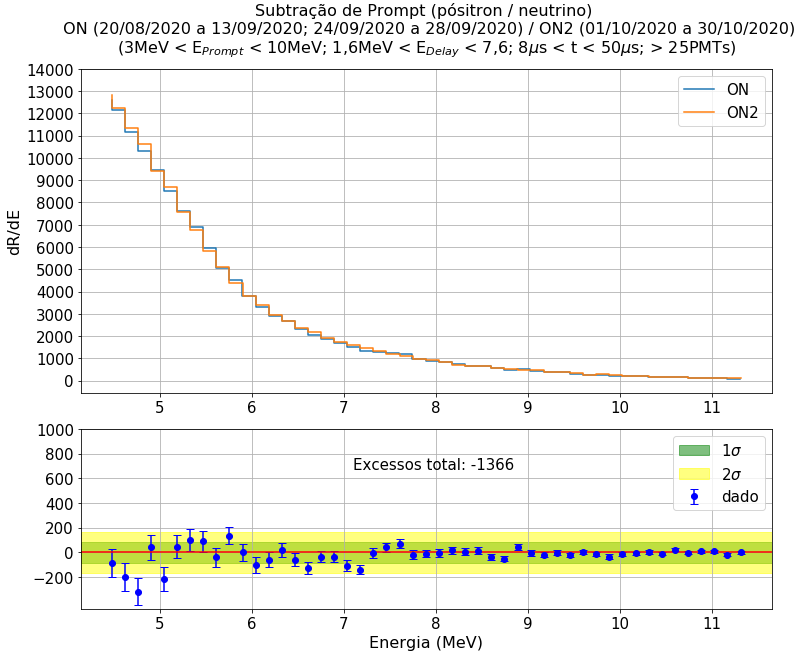

Excessos total
-1366
Excessos até 7MeV
-1080
Excessos até 6,5MeV
-883


In [81]:


fig=plt.figure(figsize=(12,5))

plt.rcParams.update({'font.size': 15})


hist1_ON, bins1_ON = np.histogram(gnh_PDP_ON, bins=maxElement)
hist1_OFF, bins1_OFF = np.histogram(gnh_PDP_OFF, bins=maxElement)

diff_hist = hist1_ON - hist1_OFF  # somente com prompt que está relacionado com a energia do neutrino
diff_hist2 = np.append(diff_hist, [0])

#print(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF)),hist1_OFF)

axprops = dict(yticks=[])
axs = []

axs.append(fig.add_axes([0.1, 1.1, 0.8, 0.9], **axprops))
axs.append(fig.add_axes([0.1, 0.5, 0.8, 0.5], **axprops))

axs[0].plot(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_ON[1:])),hist1_ON, '-', drawstyle='steps', label='ON') ##bins1_ON possui um elemento a mais sempre
axs[0].plot(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF[1:])),hist1_OFF, '-', drawstyle='steps', label='ON2') 
axs[1].errorbar(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF[1:])),diff_hist2[1:], yerr=errbar_sigma_day[1:] , marker='o', color='blue', 
             linestyle='None', capsize=4, label='dado')

axs[0].grid(True)
axs[1].grid(True)

axs[1].axhline(0,color='red')

axs[1].axhspan(np.std(diff_hist2), np.std(diff_hist2)*-1, color='green', alpha=0.5, label=r'1$\sigma$')
axs[1].axhspan(np.std(diff_hist2)*2, np.std(diff_hist2)*-2, color='yellow', alpha=0.5, label=r'2$\sigma$')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[0].set_ylabel('dR/dE', size=16)
axs[1].set_xlabel('Energia (MeV)', size=16)
axs[0].set_yticks(np.arange(0, 15000, 1000))
axs[1].set_yticks(np.arange(-200, 1200, 200))

tl_set1 = 'ON (20/08/2020 a 13/09/2020; 24/09/2020 a 28/09/2020)'

axs[0].set_title('Subtração de Prompt (pósitron / neutrino) \n '+
                 tl_set1+' / '+
                 tl_set2+'\n'+
                 r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; > 25PMTs)', size=16,y=1.02)

axs[1].annotate('Excessos total: {:d}'.format(sum(diff_hist2)), xy=(7.1, 670))
#plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
plt.show()

print('Excessos total')
print(sum(diff_hist2))
print('Excessos até 7MeV')
print(sum(diff_hist2[:19]))
print('Excessos até 6,5MeV')
print(sum(diff_hist2[:16]))



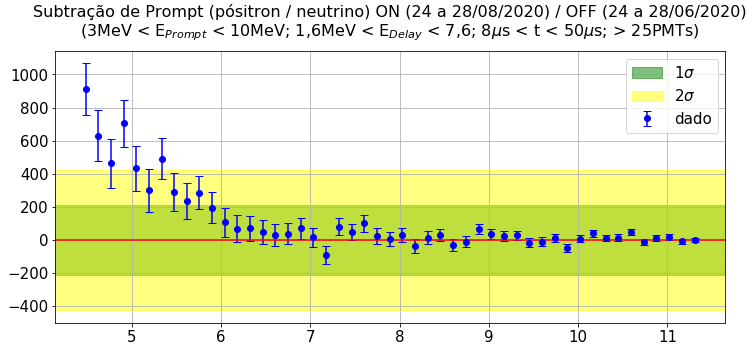

Excessos total
6302
Excessos até 7MeV
5880
Excessos até 6,5MeV
5739


In [50]:

fig=plt.figure(figsize=(12,5))

plt.rcParams.update({'font.size': 15})


hist1_ON, bins1_ON = np.histogram(gnh_PDP_ON, bins=maxElement)
hist1_OFF, bins1_OFF = np.histogram(gnh_PDP_OFF, bins=maxElement)

diff_hist = hist1_ON - hist1_OFF  # somente com prompt que está relacionado com a energia do neutrino
diff_hist2 = np.append(diff_hist, [0])

plt.errorbar(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF[1:])),diff_hist2[1:], yerr=errbar_sigma_day[1:] , marker='o', color='blue', 
             linestyle='None', capsize=4, label='dado')

plt.grid(True)
plt.grid(True)
plt.axhline(0,color='red')
plt.axhspan(np.std(diff_hist2), np.std(diff_hist2)*-1, color='green', alpha=0.5, label=r'1$\sigma$')
plt.axhspan(np.std(diff_hist2)*2, np.std(diff_hist2)*-2, color='yellow', alpha=0.5, label=r'2$\sigma$')


plt.legend(loc='upper right')

plt.title('Subtração de Prompt (pósitron / neutrino) ON (24 a 28/08/2020) / OFF (24 a 28/06/2020)\n'+
          r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; > 25PMTs)', size=16,y=1.02)
          #format(sum(h_PD_pPDF_OFF),int(totalNonSat_OFF)), size=16,y=1.02)
          
#plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
plt.show()

print('Excessos total')
print(sum(diff_hist2))
print('Excessos até 7MeV')
print(sum(diff_hist2[:19]))
print('Excessos até 6,5MeV')
print(sum(diff_hist2[:16]))

## Validação do código com outro método

hist ON
 [12598 12144 11144 10313  9451  8498  7633  6877  5935  5043  4505  3820
  3315  2902  2681  2306  2055  1885  1711  1500  1318  1306  1230  1185
   972   906   823   734   662   651   551   489   509   455   386   371
   315   269   267   209   219   215   177   165   186   139   133   123
    94]
hist Sigma ON
 [41.0, 12504.0, 12133.0, 11131.0, 10290.0, 9426.0, 8490.0, 7638.0, 6877.0, 5916.0, 5051.0, 4514.0, 3846.9999999999995, 3308.0, 2908.0, 2669.0, 2339.0, 2046.0, 1896.0, 1714.0, 1497.0, 1319.0, 1310.0, 1239.0, 1192.0, 964.0, 920.0, 818.0, 734.0, 674.0, 653.0, 544.0, 501.0, 500.00000000000006, 460.0, 399.0, 371.0, 307.0, 286.0, 266.0, 211.0, 223.0, 202.0, 188.0, 172.0, 182.0, 138.0, 135.0, 119.0, 100.0]
hist OFF
 [12089 11234 10514  9850  8746  8065  7333  6386  5645  4809  4219  3626
  3207  2833  2611  2259  2023  1846  1641  1484  1406  1225  1181  1085
   948   900   790   769   648   622   583   499   442   418   362   341
   330   278   254   257   211   175   163  

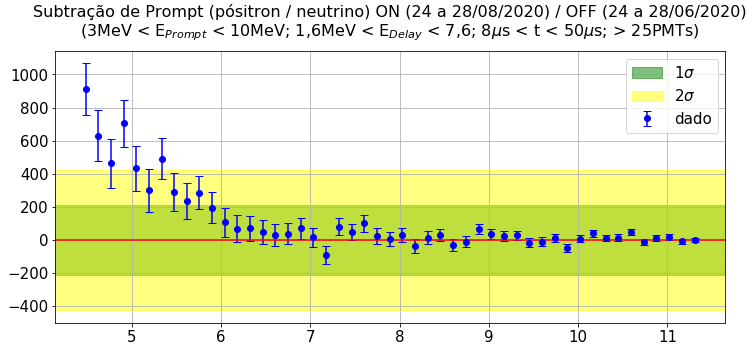

Excessos total
6302 6298.0
Excessos até 7MeV
5880
Excessos até 6,5MeV
5739


In [64]:

fig=plt.figure(figsize=(12,5))

plt.rcParams.update({'font.size': 15})


hist1_ON, bins1_ON = np.histogram(gnh_PDP_ON, bins=maxElement)
hist1_OFF, bins1_OFF = np.histogram(gnh_PDP_OFF, bins=maxElement)

#print('PDP_ON\n',gnh_PDP_ON)
print('hist ON\n',hist1_ON)
ss_ON =[x*30 for x in h_Sig_ON]
print('hist Sigma ON\n',ss_ON)

ss_OFF=[x*30 for x in h_Sig_OFF]
print('hist OFF\n',hist1_OFF)
print('hist Sigma OFF\n',ss_OFF)

diff_hist = hist1_ON - hist1_OFF  # somente com prompt que está relacionado com a energia do neutrino
diff_hist2 = np.append(diff_hist, [0])

print('hist diff\n',diff_hist)
diff_hist_Sig = [x-y for x,y in zip(ss_ON,ss_OFF)]  # somente com prompt que está relacionado com a energia do neutrino
print('hist diff Sig\n',diff_hist_Sig)

plt.errorbar(fnt_Positron2Neutrino(fnt_pe2MeV(bins1_OFF[1:])),diff_hist2[1:], yerr=errbar_sigma_day[1:] , marker='o', color='blue', 
             linestyle='None', capsize=4, label='dado')

plt.grid(True)
plt.grid(True)
plt.axhline(0,color='red')
plt.axhspan(np.std(diff_hist2), np.std(diff_hist2)*-1, color='green', alpha=0.5, label=r'1$\sigma$')
plt.axhspan(np.std(diff_hist2)*2, np.std(diff_hist2)*-2, color='yellow', alpha=0.5, label=r'2$\sigma$')


plt.legend(loc='upper right')

plt.title('Subtração de Prompt (pósitron / neutrino) ON (24 a 28/08/2020) / OFF (24 a 28/06/2020)\n'+
          r'(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; > 25PMTs)', size=16,y=1.02)
          #format(sum(h_PD_pPDF_OFF),int(totalNonSat_OFF)), size=16,y=1.02)
          
#plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
plt.show()

print('Excessos total')
print(sum(diff_hist2),sum(diff_hist_Sig))
print('Excessos até 7MeV')
print(sum(diff_hist2[:19]))
print('Excessos até 6,5MeV')
print(sum(diff_hist2[:16]))

## Load events for time interval

In [11]:
def fnt_process_list_Time (p_list, p_h_PDP, p_h_PDD, p_h_PDT, p_h_PD_pPDF, p_list_bins):
    i_day = 0
    p_totalPositrons = 0
    p_totalNonSat = 0
    p_count_bin = [ [] for y in range(len(p_list)) ]
    p_dp_bin = [ [] for y in range(len(p_list)) ]
    p_dpr_bin = [ [] for y in range(len(p_list)) ]                      

    for sListDt in p_list:
        yyyy=int(sListDt[0:4]); mm=int(sListDt[4:6]); dd=int(sListDt[6:8])
    
        sDate = '{0:d}-{1:0>2d}-{2:0>2d}'.format(yyyy,mm,dd)
        sDir='data/{0:d}{1:0>2d}{2:0>2d}'.format(yyyy,mm,dd)
        print(sDir)
        lista = find_interval_date_pair(sDate,sDate,sDir)
        p_h_NonSat = []

        for file in lista:
            df = pd.read_parquet(file)
            dff = df[(df['p_satured']==0)&(df['d_satured']==0)
                           # &(fnt_pe2MeV(df['p_Total_pe'])>=3)&(fnt_pe2MeV(df['p_Total_pe'])<=10)
                           # &(fnt_pe2MeV(df['d_Total_pe'])>=1.6)&(fnt_pe2MeV(df['d_Total_pe'])<=7.12)
                            &(df['d_timeInverval']>=100)  #&(df['d_timeInverval']<=50)
                           # &(df['d_mPMTs']>=25)
                    ]
            p_h_PDP.extend(dff['p_Total_pe'].values)
            p_h_PDD.extend(dff['d_Total_pe'].values)
            p_h_PDT.extend(dff['d_timeInverval'].values)
            p_h_PD_pPDF.extend(dff['p_PDF'].values)

            dfns = df[(df['p_satured']==0)&(df['d_satured']==0)]

            p_totalPositrons += df.count()[0]
            p_totalNonSat += dfns.count()[0]

            p_h_NonSat.extend(dff['p_Total_pe'].values)            

            #print(p_totalPositrons)
            #break
                
        print('calculando bin')
                      
        p_bin_NonSat = [ [] for y in range(len(p_list_bins)) ]
                      
        for iw in range(len(p_h_NonSat)):
            i_b_pos = fnt_search_pos(p_h_NonSat[iw])
            if (i_b_pos!=-1):
                p_bin_NonSat[i_b_pos].append(p_h_NonSat[iw])
        
        for sb in range(len(p_list_bins)):
            p_count_bin[i_day].append(len(p_bin_NonSat[sb]))

        for dpb in range(len(p_list_bins)):
            p_dp_bin[i_day].append(np.std(p_bin_NonSat[dpb]))
            p_dpr_bin[i_day].append(np.std(p_bin_NonSat[dpb])/len(p_bin_NonSat[dpb]))

        i_day += 1
        #break   ## Somente 1 dia de runs

    print('calculando sigmas')
    p_sigma_bin = []
    p_sigmar_bin = []
    p_std_bin = []
    for sbr in range(len(p_list_bins)):
        cday_NSat = []
        cday_Relat = []
        cday_Std = []
        for dd in range(i_day):
            cday_NSat.append(p_count_bin[dd][sbr])
            cday_Relat.append(p_dpr_bin[dd][sbr])
            cday_Std.append(p_dp_bin[dd][sbr])
            
        p_sigma_bin.append(np.sum(cday_NSat)/i_day)  # contagem de eventos/dia dividido pela qtde de dias
        p_sigmar_bin.append(np.sum(cday_Relat)/i_day) # contagem de desvio padrao/dia dividido pela qtde de dias
        p_std_bin.append(np.sum(cday_Std)/i_day) # contagem de desvio padrao relativo/dia (dp/qtde de eventos do bin) dividido pela qtde de dias

    return p_totalPositrons, p_totalNonSat, p_sigma_bin, p_sigmar_bin, p_std_bin


In [12]:
print('Inicio',datetime.datetime.now())
hT_PDP_OFF = []
hT_PDD_OFF = []
hT_PDT_OFF = []
hT_PD_pPDF_OFF = []
T_totalPositrons_OFF = 0
T_totalNonSat_OFF = 0
hT_Sig_OFF = []
hT_SigR_OFF = []
hT_Std_OFF = []

T_totalPositrons_OFF, T_totalNonSat_OFF, hT_Sig_OFF, hT_SigR_OFF, hT_Std_OFF = fnt_process_list_Time(list_OFF, hT_PDP_OFF, hT_PDD_OFF, hT_PDT_OFF, hT_PD_pPDF_OFF, bins_interval)
                            
print(len(hT_PDP_OFF))
print(len(hT_PDD_OFF))
print(len(hT_PDT_OFF))
print('Em 5 dias: ',T_totalPositrons_OFF)
print('Por dia: ',T_totalPositrons_OFF/5)
print('Em Hz: ',T_totalPositrons_OFF/5/86400) 
print('Em 5 dias (NS): ',T_totalNonSat_OFF)
print('Por dia (NS): ',T_totalNonSat_OFF/5)
print('Em Hz (NS): ',T_totalNonSat_OFF/5/86400) 

        
print('Fim',datetime.datetime.now())

Inicio 2023-08-08 01:59:19.319897
data/20200629
calculando bin
data/20200630
calculando bin
data/20200701
calculando bin
data/20200702
calculando bin
data/20200703
calculando bin
calculando sigmas
51350493
51350493
51350493
Em 5 dias:  82407776
Por dia:  16481555.2
Em Hz:  190.75874074074073
Em 5 dias (NS):  52927482
Por dia (NS):  10585496.4
Em Hz (NS):  122.51731944444445
Fim 2023-08-08 02:45:02.577202


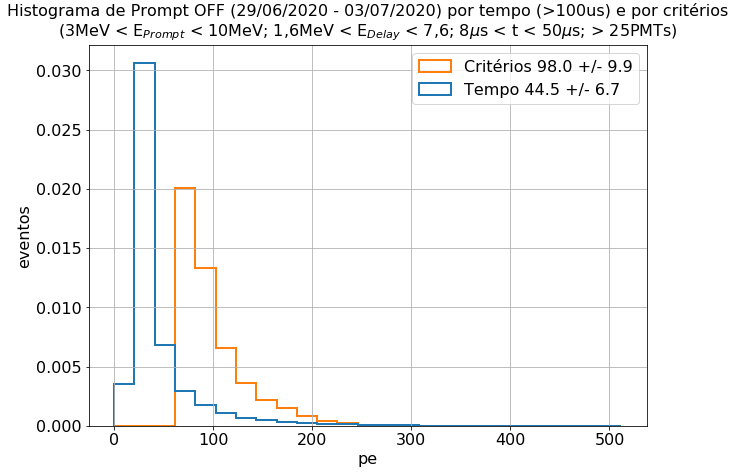

In [17]:

plt.rcParams.update({'font.size': 16})


fig=plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
#ax.set_xlim([0, 400])
    
hist_bins = 25

#plt.hist(p, bins=hist_bins, alpha=1, histtype='step', linewidth=2)
plt.hist([hT_PDP_OFF, h_PDP_OFF], bins=hist_bins, alpha=1, histtype='step', linewidth=2, density = True,
            label=['Tempo {:.1f} +/- {:.1f}'.format(np.mean(hT_PDP_OFF),(np.mean(hT_PDP_OFF)**0.5)),
                   'Critérios {:.1f} +/- {:.1f}'.format(np.mean(h_PDP_OFF),(np.mean(h_PDP_OFF)**0.5))
                  ])

plt.legend(loc='upper right')
plt.grid(True)

plt.ylabel('eventos', size=16)
plt.xlabel('pe', size=16)  #(passa-banda)
plt.title('Histograma de Prompt OFF (29/06/2020 - 03/07/2020) por tempo (>100us) e por critérios'
          '\n(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; > 25PMTs)', size=16,y=1.0)

plt.savefig('histogramas/Hist_Prompt_Tempo_x_Criterios.png')
plt.show()

In [16]:
plt.savefig('histogramas/Hist_Prompt_Tempo_x_Criterios.png')


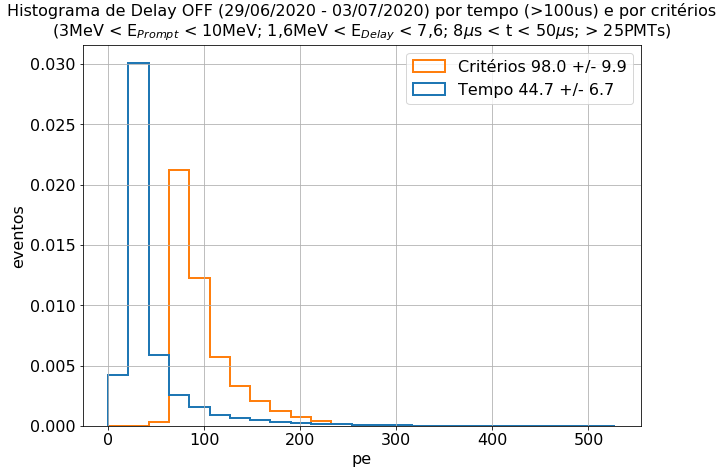

In [19]:
plt.rcParams.update({'font.size': 16})


fig=plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
#ax.set_xlim([0, 400])
    
hist_bins = 25

#plt.hist(p, bins=hist_bins, alpha=1, histtype='step', linewidth=2)
plt.hist([hT_PDD_OFF, h_PDP_OFF], bins=hist_bins, alpha=1, histtype='step', linewidth=2, density = True,
            label=['Tempo {:.1f} +/- {:.1f}'.format(np.mean(hT_PDD_OFF),(np.mean(hT_PDD_OFF)**0.5)),
                   'Critérios {:.1f} +/- {:.1f}'.format(np.mean(h_PDP_OFF),(np.mean(h_PDP_OFF)**0.5))
                  ])

plt.legend(loc='upper right')
plt.grid(True)

plt.ylabel('eventos', size=16)
plt.xlabel('pe', size=16)  #(passa-banda)
plt.title('Histograma de Delay OFF (29/06/2020 - 03/07/2020) por tempo (>100us) e por critérios'
          '\n(3MeV < E$_{Prompt}$ < 10MeV; 1,6MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; > 25PMTs)', size=16,y=1.0)

plt.savefig('histogramas/Hist_Delay_Tempo_x_Criterios.png')
plt.show()

In [90]:
print('Prompt: ')
print(fnt_MeV2DUQ(3))
print(fnt_MeV2DUQ(10))
print('Delay: ')
print(fnt_MeV2DUQ(1.6))
print(fnt_MeV2DUQ(7.12))

Prompt: 
4917.355371900826
19380.1652892562
Delay: 
2024.7933884297522
13429.752066115703


In [92]:
print('Prompt: ')
print(fnt_DUQ2MeV(785))
print(fnt_DUQ2MeV(13200))
print(fnt_DUQ2MeV(5000))
print(fnt_DUQ2MeV(11000))

Prompt: 
0.99994
7.0088
3.04
5.944
